From Switch Transformer paper:

>In deep learning, models typically reuse the same parameters for all inputs. Mixture of Experts (MoE) defies this and instead selects different parameters for each incoming example. The result is a sparsely-activated model -- with outrageous numbers of parameters -- but a constant computational cost.

A vanilla Transformer block looks like this:

```python
class ModernTransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, up):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, n_heads)
        self.mlp = nn.Sequential(
            SwishGLU(embed_dim, embed_dim * up),
            nn.Linear(embed_dim * up, embed_dim),
        )
        self.pre_attn_norm = RMSNorm(embed_dim)
        self.pre_mlp_norm = RMSNorm(embed_dim)
    
    def forward(self, x):
        x = x + self.attn(self.pre_attn_norm(x))
        x = x + self.mlp(self.pre_mlp_norm(x))
        return x
```

The Mixture-of-Experts layer replaces the MLP layer. Instead of having one MLP layer, we have `num_experts` different MLP layers called *experts*.

The idea is to process a contextualized token, by sending it to a subset of experts. In this way we could efficiently increase the number of parameters of the model without affecting computational cost too much.

First, the token is fed into *router*, which determines to which experts a token should go to be processed. For computational reasons, there is a fixed limit on:
* how many tokens an expert can process, and
* by how many experts a token is processed.

# Grading
Your task is to implement a Mixture of Experts layer. You can get points for the following subtasks:
1.  (5 points) Naive implementation of MoE layer that works with `num_experts_per_token>=1`
2.  (5 points) Well-vectorized implementation of MoE layer that works with `num_experts_per_token=1`
3.  (5 points) Implementation of a script testing for 1. 2. implementations output equivalence and performance superiority of 2.
4.  (5 points) Well-vectorized implementation of MoE layer that works with `num_experts_per_token>=1`
5.  (Bonus 5 points) Use Huggingface's Trainer class and compare performance of randomly initialized MoE Transformer and standard Transformer on `https://huggingface.co/datasets/imdb` dataset.

20 points scored in this task is equivalent to at least 16% points achievable in this course.

Please submit your assignments until 15th of April, 18:00 CET.

# Rules
- You shouldn't change basic `forward` and `initialization` signatures of the main classes: `Router` and `MoE`. You can add additional arguments with default values.
- As an assignment, provide a Jupyter notebook with a short introduction at the top of what has been done and where.
- You can add or remove any other classes, though you should keep the behaviour of `MLP` class somehow.
- Sensible vectorization is good enough for the maximum amount of points. There is no need to optimize performance to the max, just show that you can identify opportunities for vectorization and you are able to implement complex vectorizations.
- If in doubt, direct questions to either Jan Ludziejewski or Juliusz Straszyński.
- A notebook that is hard to grade (crashing, obfuscated) might be scored for 0 points.

# Hints
- First, write a naive implementation, vectorized operations might be hard to analyze for correctness.
- You can make randomness deterministic by appropriate torch functions.
- If you have a hard time fulfilling fair randomness for token discarding, you can try keeping the earlier tokens.

In [1]:
%pip install torch_tb_profiler einops
%pip install transformers[torch]  # Installs transformers and its PyTorch dependencies
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1

In [2]:
from torch import nn
import torch
from transformers import PretrainedConfig
import torch.nn.functional as F
from einops import einsum

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, config.hidden_size),
        )

    def forward(self, x):
        return self.mlp(x)

# Router
The router is a module which assigns tokens to experts. It answers two questions:
1. Which tokens should be assigned to which expert.
2. How much weight should be assigned to each expert. The weight is determined by similarity between the token embedding and the expert embedding

The following conditions must be satisfied:
1. The routing weights must sum to 1 for each token and be non-negative
2. A token should have exactly `num_experts_per_token` non-zero weights

In [3]:
# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, num_experts] - expert routing weights
class Router(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts_per_token = config.num_experts_per_token
        self.hidden_size = config.hidden_size
        self.num_experts = config.num_experts

        self.expert_embeddings = nn.Parameter(torch.randn(self.num_experts, self.hidden_size))
        torch.nn.init.kaiming_uniform_(self.expert_embeddings, nonlinearity='linear')

    def forward(self, x):
        pass

The MoE module is a module which wraps around a set of expert modules and a router module.

It takes input embeddings and routes them to the experts.

Each token is processed individually by a subset of experts.

The output token embedding is a weighted sum of the expert outputs.

The weights are determined by the router module.

The subset of experts is determined by non-zero weights in the routing output.

Additionally each expert might process at most `expert_capacity = ceil((batch_size * seq_len) / num_experts * capacity_factor)` tokens

Superfluous tokens to be discarded by a particular expert should be selected uniformly at random.

Discarding should be equivalent to setting the appropriate routing weight to 0, while other weights remain the same.

This means that a token is processed by at most num_experts_per_token experts with a sum of weights of at most 1.

Specifically, this could mean that a token is processed by 0 experts - in this case the resulting embedding should be a zero tensor.

In [4]:
import math

# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, hidden_size] - output embeddings
class MoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts = config.num_experts
        self.hidden_size = config.hidden_size
        self.num_experts_per_token = config.num_experts_per_token
        self.capacity_factor = config.capacity_factor

        # You can change experts representation if you want
        self.experts = nn.ModuleList([MLP(config) for _ in range(self.num_experts)])
        self.router = Router(config)

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        expert_capacity = math.ceil(batch_size * seq_len / self.num_experts * self.capacity_factor)
        pass

# Configurations

In [5]:
base_config = dict(
    vocab_size=5000,
    max_position_embeddings=256,
    num_attention_heads=8,
    num_hidden_layers=4,
    hidden_dropout_prob=0.1,
    hidden_size=128,
    intermediate_size=512,
    num_labels=2
)

standard_config = PretrainedConfig(
    **base_config,
    ff_cls=MLP
)

moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=1,
    ff_cls=MoE
)

# Basic Transformer-related classes

In [6]:
from einops import rearrange

class Embedding(nn.Module):
  def __init__(self, config):
    super(Embedding, self).__init__()
    self.word_embed = nn.Embedding(config.vocab_size, config.hidden_size)
    self.pos_embed = nn.Embedding(config.max_position_embeddings, config.hidden_size)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, x):
    batch_size, seq_length = x.shape
    device = x.device
    positions = torch.arange(0, seq_length).expand(
        batch_size, seq_length).to(device)
    embedding = self.word_embed(x) + self.pos_embed(positions)
    return self.dropout(embedding)


class MHSelfAttention(nn.Module):
    def __init__(self, config: PretrainedConfig):
        super(MHSelfAttention, self).__init__()
        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.head_size = self.hidden_size // self.num_attention_heads
        self.num_attention_heads = config.num_attention_heads
        self.qkv = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias=False)

    def forward(self, embeddings):
        batch_size, seq_length, hidden_size = embeddings.size()

        result = self.qkv(embeddings)
        q, k, v = rearrange(result, 'b s (qkv nah hdsz) -> qkv b nah s hdsz', nah=self.num_attention_heads, qkv=3).unbind(0)

        attention_scores = torch.matmul(q, k.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(hidden_size)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        contextualized_layer = torch.matmul(attention_probs, v)

        outputs = rearrange(contextualized_layer, 'b nah s hdsz -> b s (nah hdsz)')
        return outputs

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MHSelfAttention(config)
        self.norm1 = nn.LayerNorm(config.hidden_size)
        self.norm2 = nn.LayerNorm(config.hidden_size)
        self.intermediate = config.ff_cls(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x =  x + self.norm1(self.dropout(self.attention(x)))
        x =  x + self.norm2(self.dropout(self.intermediate(x)))
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embedding(config)
        self.layer = nn.Sequential(*[TransformerBlock(config) for _ in range(config.num_hidden_layers)])
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, labels=None):
        embedding_output = self.embeddings(input_ids)
        encoding = self.layer(embedding_output)
        pooled_encoding = encoding.mean(dim=1)
        logits = self.classifier(pooled_encoding)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {
            'loss': loss,
            'logits': logits,
        }

# Tokenizer training

In [7]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [8]:
from tokenizers import ByteLevelBPETokenizer
from datasets import load_dataset
from tokenizers.processors import BertProcessing

dataset = load_dataset('imdb')

tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(
    dataset['train']['text'],
    vocab_size=base_config['vocab_size'],
    special_tokens=["<s>", "</s>", "<pad>"],
    min_frequency=2
)
tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)

tokenizer.enable_truncation(max_length=base_config['max_position_embeddings'])
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>", length=base_config['max_position_embeddings'])
tokenizer.model_max_length = base_config['max_position_embeddings']
tokenizer.pad_token = "<pad>"

from transformers import Trainer, TrainingArguments

def tokenize(row):
    return {
        'input_ids': tokenizer.encode(row['text']).ids,
    }

tokenized_dataset = dataset.map(tokenize)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

# **Setting seed for reproducibility.**

In [9]:
# https://pytorch.org/docs/stable/notes/randomness.html

torch.manual_seed(0)

# **1. Naive implementation of MoE layer that works with num_experts_per_token>=1 and leftmost token choosing strategy.**

In [10]:
# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, num_experts] - expert routing weights
class Router(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts_per_token = config.num_experts_per_token
        self.hidden_size = config.hidden_size
        self.num_experts = config.num_experts

        self.expert_embeddings = nn.Parameter(torch.randn(self.num_experts, self.hidden_size))
        torch.nn.init.kaiming_uniform_(self.expert_embeddings, nonlinearity='linear')

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        similarity = einsum(x, self.expert_embeddings, 'b s h, e h -> b s e')
        top_experts = torch.topk(similarity, self.num_experts_per_token)
        softmaxed_topk_values = F.softmax(top_experts.values, dim=-1)
        mask = torch.zeros_like(similarity, dtype=torch.bool)
        mask = mask.scatter_(-1, top_experts.indices, 1)
        routing_weights = torch.zeros_like(similarity)
        routing_weights[mask] = softmaxed_topk_values.flatten()

        return routing_weights

In [11]:
# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, hidden_size] - output embeddings
class NaiveMoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts = config.num_experts
        self.hidden_size = config.hidden_size
        self.num_experts_per_token = config.num_experts_per_token
        self.capacity_factor = config.capacity_factor

        # You can change experts representation if you want
        self.experts = nn.ModuleList([MLP(config) for _ in range(self.num_experts)])
        self.router = Router(config)

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        expert_capacity = torch.ceil(torch.tensor(batch_size * seq_len / self.num_experts * self.capacity_factor, device=x.device, dtype=torch.int))
        routing_weights = self.router(x)
        for i in range(self.num_experts):
            token_indices = torch.nonzero(routing_weights[:, :, i], as_tuple=False)
            if token_indices.shape[0] > expert_capacity:
                routing_weights[token_indices[expert_capacity:, 0], token_indices[expert_capacity:, 1], i] = 0

        expert_outputs = torch.zeros(batch_size, seq_len, self.hidden_size, device=x.device)
        for i in range(self.num_experts):
            token_indices = torch.nonzero(routing_weights[:, :, i], as_tuple=False)
            expert_outputs[token_indices[:, 0], token_indices[:, 1]] += self.experts[i](x[token_indices[:, 0], token_indices[:, 1]]) * routing_weights[token_indices[:, 0], token_indices[:, 1], i].reshape(-1, 1)

        return expert_outputs

In [12]:
from torch.utils.data import DataLoader

naive_moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=4,
    ff_cls=NaiveMoE
)

train_loader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16, shuffle=False)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(naive_moe_config).to(DEVICE)
# model = TransformerClassifier(standard_config).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
from tqdm import tqdm

NUM_OF_EPOCHS = 20

for epoch in range(NUM_OF_EPOCHS):
    model.train()
    train_progress_bar = tqdm(train_loader, desc=f'Train, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
    running_loss = 0.
    for i, batch in enumerate(train_progress_bar):
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        loss = model(x, y)['loss']
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # avg loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        test_progress_bar = tqdm(test_loader, desc=f'Test, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
        for batch in test_progress_bar:
            x, y = batch['input_ids'], batch['label']
            x = torch.stack(x, dim=1).to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)['logits']
            total_loss += F.cross_entropy(logits, y, reduction='sum').item()
            total_samples += y.shape[0]
            correct_samples += (logits.argmax(dim=-1) == y).sum().item()

        print(f'Epoch {epoch + 1}, loss: {total_loss / total_samples}, accuracy: {correct_samples / total_samples}')

Train, Epoch 1 / 20:   1%|          | 13/1563 [00:00<01:25, 18.18it/s]

batch 10 loss: 1.2033341526985168


Train, Epoch 1 / 20:   1%|▏         | 23/1563 [00:01<01:27, 17.63it/s]

batch 20 loss: 0.9138149499893189


Train, Epoch 1 / 20:   2%|▏         | 33/1563 [00:01<01:22, 18.52it/s]

batch 30 loss: 0.8427469909191132


Train, Epoch 1 / 20:   3%|▎         | 43/1563 [00:02<01:19, 19.17it/s]

batch 40 loss: 0.9648739159107208


Train, Epoch 1 / 20:   3%|▎         | 52/1563 [00:02<01:16, 19.80it/s]

batch 50 loss: 0.7992942154407501


Train, Epoch 1 / 20:   4%|▍         | 62/1563 [00:03<01:34, 15.94it/s]

batch 60 loss: 0.877907806634903


Train, Epoch 1 / 20:   5%|▍         | 72/1563 [00:03<01:22, 18.12it/s]

batch 70 loss: 0.9652309834957122


Train, Epoch 1 / 20:   5%|▌         | 83/1563 [00:04<01:18, 18.93it/s]

batch 80 loss: 0.7334680557250977


Train, Epoch 1 / 20:   6%|▌         | 93/1563 [00:05<01:17, 18.96it/s]

batch 90 loss: 0.6813925802707672


Train, Epoch 1 / 20:   7%|▋         | 103/1563 [00:05<01:17, 18.80it/s]

batch 100 loss: 0.7527759790420532


Train, Epoch 1 / 20:   7%|▋         | 113/1563 [00:06<01:17, 18.72it/s]

batch 110 loss: 0.7054231286048889


Train, Epoch 1 / 20:   8%|▊         | 123/1563 [00:06<01:15, 18.99it/s]

batch 120 loss: 0.678711074590683


Train, Epoch 1 / 20:   9%|▊         | 133/1563 [00:07<01:26, 16.53it/s]

batch 130 loss: 0.6902370393276215


Train, Epoch 1 / 20:   9%|▉         | 143/1563 [00:07<01:25, 16.52it/s]

batch 140 loss: 0.6843487322330475


Train, Epoch 1 / 20:  10%|▉         | 153/1563 [00:08<01:34, 14.92it/s]

batch 150 loss: 0.7010039031505585


Train, Epoch 1 / 20:  10%|█         | 162/1563 [00:09<01:18, 17.80it/s]

batch 160 loss: 0.7291490793228149


Train, Epoch 1 / 20:  11%|█         | 172/1563 [00:09<01:12, 19.09it/s]

batch 170 loss: 0.7387413561344147


Train, Epoch 1 / 20:  12%|█▏        | 182/1563 [00:10<01:12, 18.97it/s]

batch 180 loss: 0.6992709934711456


Train, Epoch 1 / 20:  12%|█▏        | 192/1563 [00:10<01:10, 19.54it/s]

batch 190 loss: 0.6891151666641235


Train, Epoch 1 / 20:  13%|█▎        | 203/1563 [00:11<01:09, 19.43it/s]

batch 200 loss: 0.6880708396434784


Train, Epoch 1 / 20:  14%|█▎        | 213/1563 [00:11<01:09, 19.37it/s]

batch 210 loss: 0.6906685948371887


Train, Epoch 1 / 20:  14%|█▍        | 223/1563 [00:12<01:08, 19.46it/s]

batch 220 loss: 0.6733020663261413


Train, Epoch 1 / 20:  15%|█▍        | 232/1563 [00:12<01:07, 19.72it/s]

batch 230 loss: 0.7311889231204987


Train, Epoch 1 / 20:  16%|█▌        | 243/1563 [00:13<01:08, 19.33it/s]

batch 240 loss: 0.6868929386138916


Train, Epoch 1 / 20:  16%|█▌        | 253/1563 [00:13<01:07, 19.48it/s]

batch 250 loss: 0.7263181626796722


Train, Epoch 1 / 20:  17%|█▋        | 262/1563 [00:14<01:05, 19.80it/s]

batch 260 loss: 0.7165864109992981


Train, Epoch 1 / 20:  17%|█▋        | 273/1563 [00:14<01:07, 19.19it/s]

batch 270 loss: 0.6461679220199585


Train, Epoch 1 / 20:  18%|█▊        | 283/1563 [00:15<01:06, 19.37it/s]

batch 280 loss: 0.6539095759391784


Train, Epoch 1 / 20:  19%|█▊        | 292/1563 [00:15<01:06, 19.10it/s]

batch 290 loss: 0.6880915343761445


Train, Epoch 1 / 20:  19%|█▉        | 303/1563 [00:16<01:05, 19.32it/s]

batch 300 loss: 0.6141978979110718


Train, Epoch 1 / 20:  20%|██        | 313/1563 [00:16<01:03, 19.63it/s]

batch 310 loss: 0.6594462335109711


Train, Epoch 1 / 20:  21%|██        | 324/1563 [00:17<01:02, 19.78it/s]

batch 320 loss: 0.6481190741062164


Train, Epoch 1 / 20:  21%|██▏       | 333/1563 [00:17<01:04, 19.10it/s]

batch 330 loss: 0.5855267524719239


Train, Epoch 1 / 20:  22%|██▏       | 343/1563 [00:18<01:03, 19.22it/s]

batch 340 loss: 0.6383742272853852


Train, Epoch 1 / 20:  23%|██▎       | 353/1563 [00:19<01:12, 16.58it/s]

batch 350 loss: 0.6169226199388504


Train, Epoch 1 / 20:  23%|██▎       | 363/1563 [00:19<01:16, 15.78it/s]

batch 360 loss: 0.6006479769945144


Train, Epoch 1 / 20:  24%|██▍       | 373/1563 [00:20<01:17, 15.45it/s]

batch 370 loss: 0.5948901355266571


Train, Epoch 1 / 20:  25%|██▍       | 383/1563 [00:21<01:10, 16.68it/s]

batch 380 loss: 0.6531133234500885


Train, Epoch 1 / 20:  25%|██▌       | 392/1563 [00:21<01:02, 18.87it/s]

batch 390 loss: 0.6320235669612885


Train, Epoch 1 / 20:  26%|██▌       | 402/1563 [00:22<01:01, 18.99it/s]

batch 400 loss: 0.591797998547554


Train, Epoch 1 / 20:  26%|██▋       | 413/1563 [00:22<00:58, 19.50it/s]

batch 410 loss: 0.594695508480072


Train, Epoch 1 / 20:  27%|██▋       | 423/1563 [00:23<01:00, 18.81it/s]

batch 420 loss: 0.5109083950519562


Train, Epoch 1 / 20:  28%|██▊       | 433/1563 [00:23<00:58, 19.29it/s]

batch 430 loss: 0.6194938391447067


Train, Epoch 1 / 20:  28%|██▊       | 443/1563 [00:24<00:59, 18.75it/s]

batch 440 loss: 0.6324471950531005


Train, Epoch 1 / 20:  29%|██▉       | 453/1563 [00:24<00:57, 19.15it/s]

batch 450 loss: 0.6117632180452347


Train, Epoch 1 / 20:  30%|██▉       | 462/1563 [00:25<00:56, 19.37it/s]

batch 460 loss: 0.5558372169733048


Train, Epoch 1 / 20:  30%|███       | 471/1563 [00:25<00:55, 19.72it/s]

batch 470 loss: 0.5228474557399749


Train, Epoch 1 / 20:  31%|███       | 483/1563 [00:26<00:54, 19.69it/s]

batch 480 loss: 0.5589699894189835


Train, Epoch 1 / 20:  32%|███▏      | 493/1563 [00:26<00:54, 19.73it/s]

batch 490 loss: 0.5864254713058472


Train, Epoch 1 / 20:  32%|███▏      | 503/1563 [00:27<00:55, 19.02it/s]

batch 500 loss: 0.5574246495962143


Train, Epoch 1 / 20:  33%|███▎      | 512/1563 [00:27<00:53, 19.54it/s]

batch 510 loss: 0.5965816140174866


Train, Epoch 1 / 20:  33%|███▎      | 522/1563 [00:28<00:56, 18.45it/s]

batch 520 loss: 0.5464736521244049


Train, Epoch 1 / 20:  34%|███▍      | 532/1563 [00:28<00:55, 18.46it/s]

batch 530 loss: 0.568380719423294


Train, Epoch 1 / 20:  35%|███▍      | 541/1563 [00:29<00:53, 19.08it/s]

batch 540 loss: 0.6813136011362075


Train, Epoch 1 / 20:  35%|███▌      | 552/1563 [00:29<00:54, 18.68it/s]

batch 550 loss: 0.6177334904670715


Train, Epoch 1 / 20:  36%|███▌      | 563/1563 [00:30<00:51, 19.54it/s]

batch 560 loss: 0.6047531843185425


Train, Epoch 1 / 20:  37%|███▋      | 571/1563 [00:30<00:55, 17.72it/s]

batch 570 loss: 0.6027579754590988


Train, Epoch 1 / 20:  37%|███▋      | 583/1563 [00:31<01:02, 15.78it/s]

batch 580 loss: 0.5948746383190155


Train, Epoch 1 / 20:  38%|███▊      | 591/1563 [00:32<01:04, 15.06it/s]

batch 590 loss: 0.5811483830213546


Train, Epoch 1 / 20:  39%|███▊      | 603/1563 [00:33<01:04, 14.83it/s]

batch 600 loss: 0.5499907732009888


Train, Epoch 1 / 20:  39%|███▉      | 613/1563 [00:33<00:52, 18.24it/s]

batch 610 loss: 0.5348590016365051


Train, Epoch 1 / 20:  40%|███▉      | 623/1563 [00:34<00:50, 18.79it/s]

batch 620 loss: 0.44903946220874785


Train, Epoch 1 / 20:  40%|████      | 633/1563 [00:34<00:49, 18.96it/s]

batch 630 loss: 0.5378324419260025


Train, Epoch 1 / 20:  41%|████      | 643/1563 [00:35<00:48, 18.97it/s]

batch 640 loss: 0.5037701457738877


Train, Epoch 1 / 20:  42%|████▏     | 653/1563 [00:35<00:47, 19.31it/s]

batch 650 loss: 0.5987352877855301


Train, Epoch 1 / 20:  42%|████▏     | 662/1563 [00:36<00:47, 19.15it/s]

batch 660 loss: 0.6033804237842559


Train, Epoch 1 / 20:  43%|████▎     | 672/1563 [00:36<00:45, 19.38it/s]

batch 670 loss: 0.5475032776594162


Train, Epoch 1 / 20:  44%|████▎     | 682/1563 [00:37<00:45, 19.16it/s]

batch 680 loss: 0.5796170949935913


Train, Epoch 1 / 20:  44%|████▍     | 693/1563 [00:37<00:44, 19.56it/s]

batch 690 loss: 0.5290399789810181


Train, Epoch 1 / 20:  45%|████▍     | 702/1563 [00:38<00:44, 19.27it/s]

batch 700 loss: 0.5218061238527298


Train, Epoch 1 / 20:  46%|████▌     | 713/1563 [00:38<00:43, 19.61it/s]

batch 710 loss: 0.5473307013511658


Train, Epoch 1 / 20:  46%|████▋     | 723/1563 [00:39<00:43, 19.22it/s]

batch 720 loss: 0.5848041355609894


Train, Epoch 1 / 20:  47%|████▋     | 733/1563 [00:39<00:43, 19.12it/s]

batch 730 loss: 0.5667793214321136


Train, Epoch 1 / 20:  47%|████▋     | 742/1563 [00:40<00:42, 19.17it/s]

batch 740 loss: 0.5575024068355561


Train, Epoch 1 / 20:  48%|████▊     | 753/1563 [00:40<00:41, 19.53it/s]

batch 750 loss: 0.5108521848917007


Train, Epoch 1 / 20:  49%|████▉     | 763/1563 [00:41<00:41, 19.06it/s]

batch 760 loss: 0.584150618314743


Train, Epoch 1 / 20:  49%|████▉     | 773/1563 [00:41<00:40, 19.46it/s]

batch 770 loss: 0.480792498588562


Train, Epoch 1 / 20:  50%|█████     | 784/1563 [00:42<00:39, 19.53it/s]

batch 780 loss: 0.5570266991853714


Train, Epoch 1 / 20:  51%|█████     | 793/1563 [00:42<00:39, 19.57it/s]

batch 790 loss: 0.48405068218708036


Train, Epoch 1 / 20:  51%|█████▏    | 803/1563 [00:43<00:46, 16.37it/s]

batch 800 loss: 0.4478864729404449


Train, Epoch 1 / 20:  52%|█████▏    | 813/1563 [00:44<00:46, 16.10it/s]

batch 810 loss: 0.5679599046707153


Train, Epoch 1 / 20:  53%|█████▎    | 821/1563 [00:44<00:51, 14.31it/s]

batch 820 loss: 0.4621555358171463


Train, Epoch 1 / 20:  53%|█████▎    | 834/1563 [00:45<00:40, 17.83it/s]

batch 830 loss: 0.42560127675533294


Train, Epoch 1 / 20:  54%|█████▍    | 843/1563 [00:45<00:37, 19.20it/s]

batch 840 loss: 0.4886484816670418


Train, Epoch 1 / 20:  55%|█████▍    | 853/1563 [00:46<00:35, 19.82it/s]

batch 850 loss: 0.5115957766771316


Train, Epoch 1 / 20:  55%|█████▌    | 862/1563 [00:46<00:34, 20.23it/s]

batch 860 loss: 0.5167519673705101


Train, Epoch 1 / 20:  56%|█████▌    | 873/1563 [00:47<00:34, 19.95it/s]

batch 870 loss: 0.48486549556255343


Train, Epoch 1 / 20:  56%|█████▋    | 882/1563 [00:47<00:33, 20.08it/s]

batch 880 loss: 0.4485791951417923


Train, Epoch 1 / 20:  57%|█████▋    | 891/1563 [00:48<00:35, 19.15it/s]

batch 890 loss: 0.4570061445236206


Train, Epoch 1 / 20:  58%|█████▊    | 904/1563 [00:49<00:33, 19.97it/s]

batch 900 loss: 0.5517386436462403


Train, Epoch 1 / 20:  58%|█████▊    | 912/1563 [00:49<00:34, 18.91it/s]

batch 910 loss: 0.5338814318180084


Train, Epoch 1 / 20:  59%|█████▉    | 924/1563 [00:50<00:32, 19.76it/s]

batch 920 loss: 0.4121210664510727


Train, Epoch 1 / 20:  60%|█████▉    | 932/1563 [00:50<00:32, 19.25it/s]

batch 930 loss: 0.4784955054521561


Train, Epoch 1 / 20:  60%|██████    | 942/1563 [00:50<00:31, 19.97it/s]

batch 940 loss: 0.46554372608661654


Train, Epoch 1 / 20:  61%|██████    | 953/1563 [00:51<00:31, 19.37it/s]

batch 950 loss: 0.4900284051895142


Train, Epoch 1 / 20:  62%|██████▏   | 962/1563 [00:52<00:30, 19.71it/s]

batch 960 loss: 0.45619317293167116


Train, Epoch 1 / 20:  62%|██████▏   | 972/1563 [00:52<00:31, 19.03it/s]

batch 970 loss: 0.45685319006443026


Train, Epoch 1 / 20:  63%|██████▎   | 982/1563 [00:53<00:29, 19.73it/s]

batch 980 loss: 0.5136098623275757


Train, Epoch 1 / 20:  63%|██████▎   | 991/1563 [00:53<00:29, 19.41it/s]

batch 990 loss: 0.4826166838407516


Train, Epoch 1 / 20:  64%|██████▍   | 1003/1563 [00:54<00:28, 19.80it/s]

batch 1000 loss: 0.4537782371044159


Train, Epoch 1 / 20:  65%|██████▍   | 1012/1563 [00:54<00:27, 19.82it/s]

batch 1010 loss: 0.5132469058036804


Train, Epoch 1 / 20:  65%|██████▌   | 1022/1563 [00:55<00:27, 19.96it/s]

batch 1020 loss: 0.45485312044620513


Train, Epoch 1 / 20:  66%|██████▌   | 1032/1563 [00:55<00:33, 15.91it/s]

batch 1030 loss: 0.4299334123730659


Train, Epoch 1 / 20:  67%|██████▋   | 1042/1563 [00:56<00:31, 16.80it/s]

batch 1040 loss: 0.38682681918144224


Train, Epoch 1 / 20:  67%|██████▋   | 1052/1563 [00:56<00:33, 15.38it/s]

batch 1050 loss: 0.4831730544567108


Train, Epoch 1 / 20:  68%|██████▊   | 1063/1563 [00:57<00:27, 18.46it/s]

batch 1060 loss: 0.4305664002895355


Train, Epoch 1 / 20:  69%|██████▊   | 1074/1563 [00:58<00:25, 19.45it/s]

batch 1070 loss: 0.5499860376119614


Train, Epoch 1 / 20:  69%|██████▉   | 1081/1563 [00:58<00:24, 19.83it/s]

batch 1080 loss: 0.5648777514696122


Train, Epoch 1 / 20:  70%|██████▉   | 1094/1563 [00:59<00:23, 20.15it/s]

batch 1090 loss: 0.4853793680667877


Train, Epoch 1 / 20:  71%|███████   | 1103/1563 [00:59<00:22, 20.01it/s]

batch 1100 loss: 0.43616433441638947


Train, Epoch 1 / 20:  71%|███████   | 1113/1563 [01:00<00:22, 19.61it/s]

batch 1110 loss: 0.4013599455356598


Train, Epoch 1 / 20:  72%|███████▏  | 1122/1563 [01:00<00:22, 19.87it/s]

batch 1120 loss: 0.4009762853384018


Train, Epoch 1 / 20:  72%|███████▏  | 1132/1563 [01:01<00:21, 19.88it/s]

batch 1130 loss: 0.4393373727798462


Train, Epoch 1 / 20:  73%|███████▎  | 1143/1563 [01:01<00:20, 20.02it/s]

batch 1140 loss: 0.5046923518180847


Train, Epoch 1 / 20:  74%|███████▎  | 1152/1563 [01:02<00:20, 19.99it/s]

batch 1150 loss: 0.4285038888454437


Train, Epoch 1 / 20:  74%|███████▍  | 1163/1563 [01:02<00:20, 19.76it/s]

batch 1160 loss: 0.43479354232549666


Train, Epoch 1 / 20:  75%|███████▌  | 1173/1563 [01:03<00:19, 19.92it/s]

batch 1170 loss: 0.47049427926540377


Train, Epoch 1 / 20:  76%|███████▌  | 1183/1563 [01:03<00:19, 19.69it/s]

batch 1180 loss: 0.4688050389289856


Train, Epoch 1 / 20:  76%|███████▋  | 1193/1563 [01:04<00:18, 19.58it/s]

batch 1190 loss: 0.5012555465102195


Train, Epoch 1 / 20:  77%|███████▋  | 1203/1563 [01:04<00:18, 19.74it/s]

batch 1200 loss: 0.5143014758825302


Train, Epoch 1 / 20:  78%|███████▊  | 1212/1563 [01:05<00:17, 19.72it/s]

batch 1210 loss: 0.45694091320037844


Train, Epoch 1 / 20:  78%|███████▊  | 1224/1563 [01:05<00:17, 19.84it/s]

batch 1220 loss: 0.48451325595378875


Train, Epoch 1 / 20:  79%|███████▉  | 1233/1563 [01:06<00:16, 19.53it/s]

batch 1230 loss: 0.4853356540203094


Train, Epoch 1 / 20:  79%|███████▉  | 1242/1563 [01:06<00:16, 19.77it/s]

batch 1240 loss: 0.49351574331521986


Train, Epoch 1 / 20:  80%|████████  | 1252/1563 [01:07<00:16, 18.89it/s]

batch 1250 loss: 0.4537286788225174


Train, Epoch 1 / 20:  81%|████████  | 1262/1563 [01:07<00:18, 16.30it/s]

batch 1260 loss: 0.4657557547092438


Train, Epoch 1 / 20:  81%|████████▏ | 1272/1563 [01:08<00:17, 16.28it/s]

batch 1270 loss: 0.465218648314476


Train, Epoch 1 / 20:  82%|████████▏ | 1282/1563 [01:09<00:18, 14.99it/s]

batch 1280 loss: 0.4382157474756241


Train, Epoch 1 / 20:  83%|████████▎ | 1294/1563 [01:09<00:14, 19.13it/s]

batch 1290 loss: 0.4752366542816162


Train, Epoch 1 / 20:  83%|████████▎ | 1303/1563 [01:10<00:13, 19.13it/s]

batch 1300 loss: 0.5344160974025727


Train, Epoch 1 / 20:  84%|████████▍ | 1313/1563 [01:10<00:12, 19.82it/s]

batch 1310 loss: 0.42640105783939364


Train, Epoch 1 / 20:  85%|████████▍ | 1323/1563 [01:11<00:12, 19.41it/s]

batch 1320 loss: 0.3347319424152374


Train, Epoch 1 / 20:  85%|████████▌ | 1332/1563 [01:11<00:11, 19.71it/s]

batch 1330 loss: 0.42906643897295


Train, Epoch 1 / 20:  86%|████████▌ | 1343/1563 [01:12<00:11, 19.47it/s]

batch 1340 loss: 0.4255662143230438


Train, Epoch 1 / 20:  87%|████████▋ | 1352/1563 [01:12<00:10, 19.83it/s]

batch 1350 loss: 0.40485686957836153


Train, Epoch 1 / 20:  87%|████████▋ | 1362/1563 [01:13<00:10, 19.46it/s]

batch 1360 loss: 0.3931199565529823


Train, Epoch 1 / 20:  88%|████████▊ | 1373/1563 [01:13<00:09, 20.19it/s]

batch 1370 loss: 0.4482094258069992


Train, Epoch 1 / 20:  89%|████████▊ | 1384/1563 [01:14<00:08, 19.93it/s]

batch 1380 loss: 0.461888262629509


Train, Epoch 1 / 20:  89%|████████▉ | 1392/1563 [01:14<00:08, 20.23it/s]

batch 1390 loss: 0.47674389779567716


Train, Epoch 1 / 20:  90%|████████▉ | 1403/1563 [01:15<00:08, 19.07it/s]

batch 1400 loss: 0.4375310823321342


Train, Epoch 1 / 20:  90%|█████████ | 1413/1563 [01:15<00:07, 19.75it/s]

batch 1410 loss: 0.42160905003547666


Train, Epoch 1 / 20:  91%|█████████ | 1423/1563 [01:16<00:07, 19.12it/s]

batch 1420 loss: 0.3959992229938507


Train, Epoch 1 / 20:  92%|█████████▏| 1432/1563 [01:16<00:06, 19.70it/s]

batch 1430 loss: 0.4214401230216026


Train, Epoch 1 / 20:  92%|█████████▏| 1442/1563 [01:17<00:06, 19.74it/s]

batch 1440 loss: 0.38138877749443056


Train, Epoch 1 / 20:  93%|█████████▎| 1453/1563 [01:17<00:05, 20.19it/s]

batch 1450 loss: 0.4337517753243446


Train, Epoch 1 / 20:  94%|█████████▎| 1462/1563 [01:18<00:05, 19.81it/s]

batch 1460 loss: 0.36272286921739577


Train, Epoch 1 / 20:  94%|█████████▍| 1472/1563 [01:18<00:04, 20.04it/s]

batch 1470 loss: 0.39216705560684206


Train, Epoch 1 / 20:  95%|█████████▍| 1483/1563 [01:19<00:04, 18.37it/s]

batch 1480 loss: 0.4507389485836029


Train, Epoch 1 / 20:  96%|█████████▌| 1493/1563 [01:19<00:04, 17.25it/s]

batch 1490 loss: 0.453522589802742


Train, Epoch 1 / 20:  96%|█████████▌| 1503/1563 [01:20<00:03, 15.91it/s]

batch 1500 loss: 0.38704138398170473


Train, Epoch 1 / 20:  97%|█████████▋| 1511/1563 [01:21<00:03, 15.14it/s]

batch 1510 loss: 0.4552582919597626


Train, Epoch 1 / 20:  97%|█████████▋| 1521/1563 [01:21<00:02, 17.14it/s]

batch 1520 loss: 0.42420624792575834


Train, Epoch 1 / 20:  98%|█████████▊| 1532/1563 [01:22<00:01, 16.76it/s]

batch 1530 loss: 0.388854107260704


Train, Epoch 1 / 20:  99%|█████████▊| 1541/1563 [01:22<00:01, 18.52it/s]

batch 1540 loss: 0.37162585705518725


Train, Epoch 1 / 20:  99%|█████████▉| 1552/1563 [01:23<00:00, 19.08it/s]

batch 1550 loss: 0.5589667811989785


Train, Epoch 1 / 20: 100%|██████████| 1563/1563 [01:24<00:00, 18.60it/s]


batch 1560 loss: 0.47827038168907166


Test, Epoch 1 / 20: 100%|██████████| 1563/1563 [00:37<00:00, 41.64it/s]


Epoch 1, loss: 0.4485974488687515, accuracy: 0.79136


Train, Epoch 2 / 20:   1%|          | 12/1563 [00:00<01:19, 19.48it/s]

batch 10 loss: 0.47310285568237304


Train, Epoch 2 / 20:   2%|▏         | 24/1563 [00:01<01:18, 19.72it/s]

batch 20 loss: 0.4839359313249588


Train, Epoch 2 / 20:   2%|▏         | 34/1563 [00:01<01:16, 19.92it/s]

batch 30 loss: 0.43701818883419036


Train, Epoch 2 / 20:   3%|▎         | 43/1563 [00:02<01:16, 19.74it/s]

batch 40 loss: 0.36176503002643584


Train, Epoch 2 / 20:   3%|▎         | 53/1563 [00:02<01:17, 19.45it/s]

batch 50 loss: 0.504285940527916


Train, Epoch 2 / 20:   4%|▎         | 56/1563 [00:02<01:19, 19.01it/s]


KeyboardInterrupt: 

# **2. and 4. Vectorized implementation of MoE layer that works with num_experts_per_token>=1. Satisfies 2nd and 4th part of the task.**

In [13]:
# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, hidden_size] - output embeddings
class VectorizedMoE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts = config.num_experts
        self.hidden_size = config.hidden_size
        self.num_experts_per_token = config.num_experts_per_token
        self.capacity_factor = config.capacity_factor

        # You can change experts representation if you want
        self.expert = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.expert_weights = torch.nn.Parameter(torch.stack([self.expert.weight for _ in range(self.num_experts)], dim=0))
        self.expert_biases = torch.nn.Parameter(torch.stack([self.expert.bias for _ in range(self.num_experts)], dim=0))
        self.router = Router(config)

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        expert_capacity = torch.ceil(torch.tensor(batch_size * seq_len / self.num_experts * self.capacity_factor, device=x.device, dtype=torch.int))
        routing_weights = self.router(x)
        flat_routing_weights = routing_weights.view(-1, self.num_experts)  # Shape: [batch_size * seq_len, num_experts]
        topk_values, topk_indices = flat_routing_weights.topk(k=expert_capacity, dim=0)
        mask = torch.zeros_like(flat_routing_weights).bool()
        mask.scatter_(0, topk_indices, 1)
        flat_routing_weights = flat_routing_weights * mask.float()

        x_flat = x.reshape(-1, x.size(-1))
        inputs_expanded = x_flat.unsqueeze(1).expand(-1, self.num_experts, -1)
        weighted_inputs = inputs_expanded * flat_routing_weights.unsqueeze(-1)
        combined_inputs = weighted_inputs.reshape(-1, self.hidden_size)
        combined_outputs = torch.matmul(combined_inputs, self.expert_weights.view(-1, self.hidden_size).t()) + self.expert_biases.flatten()
        combined_outputs = combined_outputs.view(self.num_experts, batch_size * seq_len, self.num_experts, self.hidden_size)
        expert_outputs = torch.sum(combined_outputs, dim=(0, 2))
        expert_outputs = expert_outputs.view(batch_size, seq_len, self.hidden_size)

        return expert_outputs

In [14]:
from torch.utils.data import DataLoader

vectorized_moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=2,
    ff_cls=VectorizedMoE
)

train_loader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16, shuffle=False)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(vectorized_moe_config).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [69]:
from tqdm import tqdm

NUM_OF_EPOCHS = 20

for epoch in range(NUM_OF_EPOCHS):
    model.train()
    train_progress_bar = tqdm(train_loader, desc=f'Train, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
    running_loss = 0.
    for i, batch in enumerate(train_progress_bar):
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        loss = model(x, y)['loss']
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # avg loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        test_progress_bar = tqdm(test_loader, desc=f'Test, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
        for batch in test_progress_bar:
            x, y = batch['input_ids'], batch['label']
            x = torch.stack(x, dim=1).to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)['logits']
            total_loss += F.cross_entropy(logits, y, reduction='sum').item()
            total_samples += y.shape[0]
            correct_samples += (logits.argmax(dim=-1) == y).sum().item()

        print(f'Epoch {epoch + 1}, loss: {total_loss / total_samples}, accuracy: {correct_samples / total_samples}')

Train, Epoch 1 / 20:   1%|          | 15/1563 [00:00<01:02, 24.94it/s]

batch 10 loss: 1.6737357199192047


Train, Epoch 1 / 20:   2%|▏         | 24/1563 [00:00<00:58, 26.40it/s]

batch 20 loss: 0.8655293881893158


Train, Epoch 1 / 20:   2%|▏         | 33/1563 [00:01<00:57, 26.83it/s]

batch 30 loss: 0.8470841646194458


Train, Epoch 1 / 20:   3%|▎         | 45/1563 [00:01<00:55, 27.13it/s]

batch 40 loss: 0.733024674654007


Train, Epoch 1 / 20:   3%|▎         | 54/1563 [00:02<00:56, 26.93it/s]

batch 50 loss: 0.6968184411525726


Train, Epoch 1 / 20:   4%|▍         | 63/1563 [00:02<00:55, 26.93it/s]

batch 60 loss: 0.7305472493171692


Train, Epoch 1 / 20:   5%|▍         | 75/1563 [00:02<00:54, 27.22it/s]

batch 70 loss: 0.6874101340770722


Train, Epoch 1 / 20:   5%|▌         | 84/1563 [00:03<00:54, 27.07it/s]

batch 80 loss: 0.7074222803115845


Train, Epoch 1 / 20:   6%|▌         | 93/1563 [00:03<00:54, 27.19it/s]

batch 90 loss: 0.7000930607318878


Train, Epoch 1 / 20:   7%|▋         | 105/1563 [00:03<00:53, 27.08it/s]

batch 100 loss: 0.6801338374614716


Train, Epoch 1 / 20:   7%|▋         | 114/1563 [00:04<00:54, 26.67it/s]

batch 110 loss: 0.6853726029396057


Train, Epoch 1 / 20:   8%|▊         | 123/1563 [00:04<00:53, 26.93it/s]

batch 120 loss: 0.7285048365592957


Train, Epoch 1 / 20:   9%|▊         | 135/1563 [00:05<00:53, 26.62it/s]

batch 130 loss: 0.7519808828830719


Train, Epoch 1 / 20:   9%|▉         | 144/1563 [00:05<00:53, 26.61it/s]

batch 140 loss: 0.6859385550022126


Train, Epoch 1 / 20:  10%|▉         | 153/1563 [00:05<00:54, 25.88it/s]

batch 150 loss: 0.7137326419353485


Train, Epoch 1 / 20:  11%|█         | 165/1563 [00:06<00:53, 26.15it/s]

batch 160 loss: 0.7339655160903931


Train, Epoch 1 / 20:  11%|█         | 174/1563 [00:06<00:52, 26.70it/s]

batch 170 loss: 0.6792468845844268


Train, Epoch 1 / 20:  12%|█▏        | 183/1563 [00:06<00:51, 27.02it/s]

batch 180 loss: 0.6521733522415161


Train, Epoch 1 / 20:  12%|█▏        | 195/1563 [00:07<00:51, 26.63it/s]

batch 190 loss: 0.6643415510654449


Train, Epoch 1 / 20:  13%|█▎        | 204/1563 [00:07<00:50, 26.82it/s]

batch 200 loss: 0.6890978813171387


Train, Epoch 1 / 20:  14%|█▎        | 213/1563 [00:08<00:50, 26.79it/s]

batch 210 loss: 0.623177993297577


Train, Epoch 1 / 20:  14%|█▍        | 225/1563 [00:08<00:52, 25.72it/s]

batch 220 loss: 0.621872353553772


Train, Epoch 1 / 20:  15%|█▍        | 234/1563 [00:08<00:54, 24.52it/s]

batch 230 loss: 0.6241680443286896


Train, Epoch 1 / 20:  16%|█▌        | 243/1563 [00:09<00:55, 23.73it/s]

batch 240 loss: 0.6759756684303284


Train, Epoch 1 / 20:  16%|█▋        | 255/1563 [00:09<00:53, 24.52it/s]

batch 250 loss: 0.7475929498672486


Train, Epoch 1 / 20:  17%|█▋        | 264/1563 [00:10<00:54, 23.95it/s]

batch 260 loss: 0.6923930644989014


Train, Epoch 1 / 20:  17%|█▋        | 273/1563 [00:10<00:56, 23.00it/s]

batch 270 loss: 0.6627489447593689


Train, Epoch 1 / 20:  18%|█▊        | 285/1563 [00:10<00:49, 25.77it/s]

batch 280 loss: 0.668479722738266


Train, Epoch 1 / 20:  19%|█▉        | 294/1563 [00:11<00:48, 26.29it/s]

batch 290 loss: 0.6592422515153885


Train, Epoch 1 / 20:  19%|█▉        | 303/1563 [00:11<00:46, 26.88it/s]

batch 300 loss: 0.6588521838188172


Train, Epoch 1 / 20:  20%|██        | 315/1563 [00:12<00:45, 27.28it/s]

batch 310 loss: 0.5975656986236573


Train, Epoch 1 / 20:  21%|██        | 324/1563 [00:12<00:46, 26.78it/s]

batch 320 loss: 0.6511506378650666


Train, Epoch 1 / 20:  21%|██▏       | 333/1563 [00:12<00:46, 26.68it/s]

batch 330 loss: 0.6404784560203552


Train, Epoch 1 / 20:  22%|██▏       | 345/1563 [00:13<00:45, 26.81it/s]

batch 340 loss: 0.5840326935052872


Train, Epoch 1 / 20:  23%|██▎       | 354/1563 [00:13<00:46, 26.26it/s]

batch 350 loss: 0.5288386821746827


Train, Epoch 1 / 20:  23%|██▎       | 363/1563 [00:13<00:44, 26.73it/s]

batch 360 loss: 0.6117234170436859


Train, Epoch 1 / 20:  24%|██▍       | 375/1563 [00:14<00:44, 26.62it/s]

batch 370 loss: 0.5792280465364457


Train, Epoch 1 / 20:  25%|██▍       | 384/1563 [00:14<00:43, 27.01it/s]

batch 380 loss: 0.5421439409255981


Train, Epoch 1 / 20:  25%|██▌       | 393/1563 [00:15<00:43, 26.91it/s]

batch 390 loss: 0.5151631236076355


Train, Epoch 1 / 20:  26%|██▌       | 405/1563 [00:15<00:43, 26.64it/s]

batch 400 loss: 0.5539482265710831


Train, Epoch 1 / 20:  26%|██▋       | 414/1563 [00:15<00:42, 26.88it/s]

batch 410 loss: 0.7145261764526367


Train, Epoch 1 / 20:  27%|██▋       | 423/1563 [00:16<00:42, 27.04it/s]

batch 420 loss: 0.603011617064476


Train, Epoch 1 / 20:  28%|██▊       | 435/1563 [00:16<00:42, 26.57it/s]

batch 430 loss: 0.619060504436493


Train, Epoch 1 / 20:  28%|██▊       | 444/1563 [00:16<00:41, 26.87it/s]

batch 440 loss: 0.5650110721588135


Train, Epoch 1 / 20:  29%|██▉       | 453/1563 [00:17<00:41, 26.89it/s]

batch 450 loss: 0.6393288373947144


Train, Epoch 1 / 20:  30%|██▉       | 465/1563 [00:17<00:41, 26.62it/s]

batch 460 loss: 0.5798300594091416


Train, Epoch 1 / 20:  30%|███       | 474/1563 [00:18<00:40, 26.91it/s]

batch 470 loss: 0.530537560582161


Train, Epoch 1 / 20:  31%|███       | 483/1563 [00:18<00:40, 26.85it/s]

batch 480 loss: 0.5983120560646057


Train, Epoch 1 / 20:  32%|███▏      | 495/1563 [00:18<00:40, 26.54it/s]

batch 490 loss: 0.5959171086549759


Train, Epoch 1 / 20:  32%|███▏      | 504/1563 [00:19<00:39, 27.00it/s]

batch 500 loss: 0.5569577544927597


Train, Epoch 1 / 20:  33%|███▎      | 513/1563 [00:19<00:39, 26.52it/s]

batch 510 loss: 0.5700141996145248


Train, Epoch 1 / 20:  34%|███▎      | 525/1563 [00:19<00:39, 26.11it/s]

batch 520 loss: 0.625014191865921


Train, Epoch 1 / 20:  34%|███▍      | 534/1563 [00:20<00:39, 26.07it/s]

batch 530 loss: 0.5141670852899551


Train, Epoch 1 / 20:  35%|███▍      | 543/1563 [00:20<00:40, 25.17it/s]

batch 540 loss: 0.5477665871381759


Train, Epoch 1 / 20:  35%|███▌      | 552/1563 [00:21<00:41, 24.15it/s]

batch 550 loss: 0.6041779518127441


Train, Epoch 1 / 20:  36%|███▌      | 564/1563 [00:21<00:41, 23.80it/s]

batch 560 loss: 0.5683021247386932


Train, Epoch 1 / 20:  37%|███▋      | 573/1563 [00:21<00:41, 23.64it/s]

batch 570 loss: 0.5514112561941147


Train, Epoch 1 / 20:  37%|███▋      | 582/1563 [00:22<00:41, 23.48it/s]

batch 580 loss: 0.5211463212966919


Train, Epoch 1 / 20:  38%|███▊      | 594/1563 [00:22<00:39, 24.35it/s]

batch 590 loss: 0.5984771996736526


Train, Epoch 1 / 20:  39%|███▊      | 603/1563 [00:23<00:37, 25.91it/s]

batch 600 loss: 0.5609478205442429


Train, Epoch 1 / 20:  39%|███▉      | 615/1563 [00:23<00:36, 26.25it/s]

batch 610 loss: 0.5560886532068252


Train, Epoch 1 / 20:  40%|███▉      | 624/1563 [00:23<00:34, 26.89it/s]

batch 620 loss: 0.5458417117595673


Train, Epoch 1 / 20:  40%|████      | 633/1563 [00:24<00:34, 27.22it/s]

batch 630 loss: 0.5639518707990646


Train, Epoch 1 / 20:  41%|████▏     | 645/1563 [00:24<00:34, 26.44it/s]

batch 640 loss: 0.5158407717943192


Train, Epoch 1 / 20:  42%|████▏     | 654/1563 [00:25<00:34, 26.65it/s]

batch 650 loss: 0.6272422879934311


Train, Epoch 1 / 20:  42%|████▏     | 663/1563 [00:25<00:33, 26.81it/s]

batch 660 loss: 0.508846977353096


Train, Epoch 1 / 20:  43%|████▎     | 675/1563 [00:25<00:33, 26.52it/s]

batch 670 loss: 0.5126281440258026


Train, Epoch 1 / 20:  44%|████▍     | 684/1563 [00:26<00:33, 26.58it/s]

batch 680 loss: 0.6103166729211807


Train, Epoch 1 / 20:  44%|████▍     | 693/1563 [00:26<00:32, 26.83it/s]

batch 690 loss: 0.5602043837308883


Train, Epoch 1 / 20:  45%|████▌     | 705/1563 [00:26<00:32, 26.81it/s]

batch 700 loss: 0.503627148270607


Train, Epoch 1 / 20:  46%|████▌     | 714/1563 [00:27<00:31, 26.70it/s]

batch 710 loss: 0.38883776366710665


Train, Epoch 1 / 20:  46%|████▋     | 723/1563 [00:27<00:31, 26.40it/s]

batch 720 loss: 0.48555305898189544


Train, Epoch 1 / 20:  47%|████▋     | 735/1563 [00:28<00:30, 26.84it/s]

batch 730 loss: 0.591180083155632


Train, Epoch 1 / 20:  48%|████▊     | 744/1563 [00:28<00:31, 26.30it/s]

batch 740 loss: 0.534302505850792


Train, Epoch 1 / 20:  48%|████▊     | 753/1563 [00:28<00:30, 26.66it/s]

batch 750 loss: 0.5373920768499374


Train, Epoch 1 / 20:  49%|████▉     | 765/1563 [00:29<00:29, 26.76it/s]

batch 760 loss: 0.513334707915783


Train, Epoch 1 / 20:  50%|████▉     | 774/1563 [00:29<00:29, 26.78it/s]

batch 770 loss: 0.5386714190244675


Train, Epoch 1 / 20:  50%|█████     | 783/1563 [00:29<00:29, 26.66it/s]

batch 780 loss: 0.5919584065675736


Train, Epoch 1 / 20:  51%|█████     | 795/1563 [00:30<00:28, 26.77it/s]

batch 790 loss: 0.46224207282066343


Train, Epoch 1 / 20:  51%|█████▏    | 804/1563 [00:30<00:28, 26.57it/s]

batch 800 loss: 0.5161768347024918


Train, Epoch 1 / 20:  52%|█████▏    | 813/1563 [00:31<00:28, 26.55it/s]

batch 810 loss: 0.4662025958299637


Train, Epoch 1 / 20:  53%|█████▎    | 825/1563 [00:31<00:27, 26.70it/s]

batch 820 loss: 0.5345560759305954


Train, Epoch 1 / 20:  53%|█████▎    | 834/1563 [00:31<00:27, 26.18it/s]

batch 830 loss: 0.5333682760596276


Train, Epoch 1 / 20:  54%|█████▍    | 843/1563 [00:32<00:27, 26.56it/s]

batch 840 loss: 0.38384081721305846


Train, Epoch 1 / 20:  55%|█████▍    | 855/1563 [00:32<00:26, 26.89it/s]

batch 850 loss: 0.44022671282291415


Train, Epoch 1 / 20:  55%|█████▌    | 864/1563 [00:32<00:28, 24.50it/s]

batch 860 loss: 0.41866436749696734


Train, Epoch 1 / 20:  56%|█████▌    | 873/1563 [00:33<00:28, 23.83it/s]

batch 870 loss: 0.5145401358604431


Train, Epoch 1 / 20:  56%|█████▋    | 882/1563 [00:33<00:29, 22.95it/s]

batch 880 loss: 0.43403363823890684


Train, Epoch 1 / 20:  57%|█████▋    | 894/1563 [00:34<00:28, 23.70it/s]

batch 890 loss: 0.4706465631723404


Train, Epoch 1 / 20:  58%|█████▊    | 903/1563 [00:34<00:28, 23.15it/s]

batch 900 loss: 0.5328051775693894


Train, Epoch 1 / 20:  59%|█████▊    | 915/1563 [00:35<00:25, 25.56it/s]

batch 910 loss: 0.4406489968299866


Train, Epoch 1 / 20:  59%|█████▉    | 924/1563 [00:35<00:24, 25.87it/s]

batch 920 loss: 0.46475242972373965


Train, Epoch 1 / 20:  60%|█████▉    | 933/1563 [00:35<00:24, 25.63it/s]

batch 930 loss: 0.4933676809072495


Train, Epoch 1 / 20:  60%|██████    | 945/1563 [00:36<00:23, 26.77it/s]

batch 940 loss: 0.4585156723856926


Train, Epoch 1 / 20:  61%|██████    | 954/1563 [00:36<00:22, 26.72it/s]

batch 950 loss: 0.44365705698728564


Train, Epoch 1 / 20:  62%|██████▏   | 963/1563 [00:36<00:22, 26.83it/s]

batch 960 loss: 0.4583744615316391


Train, Epoch 1 / 20:  62%|██████▏   | 975/1563 [00:37<00:21, 26.84it/s]

batch 970 loss: 0.5718897163867951


Train, Epoch 1 / 20:  63%|██████▎   | 984/1563 [00:37<00:21, 26.63it/s]

batch 980 loss: 0.4619895428419113


Train, Epoch 1 / 20:  64%|██████▎   | 993/1563 [00:38<00:21, 26.92it/s]

batch 990 loss: 0.491743603348732


Train, Epoch 1 / 20:  64%|██████▍   | 1005/1563 [00:38<00:20, 26.85it/s]

batch 1000 loss: 0.4765538424253464


Train, Epoch 1 / 20:  65%|██████▍   | 1014/1563 [00:38<00:20, 27.04it/s]

batch 1010 loss: 0.42705913782119753


Train, Epoch 1 / 20:  65%|██████▌   | 1023/1563 [00:39<00:20, 26.69it/s]

batch 1020 loss: 0.5147841423749924


Train, Epoch 1 / 20:  66%|██████▌   | 1035/1563 [00:39<00:19, 26.81it/s]

batch 1030 loss: 0.4200219839811325


Train, Epoch 1 / 20:  67%|██████▋   | 1044/1563 [00:39<00:19, 26.67it/s]

batch 1040 loss: 0.5175462007522583


Train, Epoch 1 / 20:  67%|██████▋   | 1053/1563 [00:40<00:19, 26.78it/s]

batch 1050 loss: 0.5052780389785767


Train, Epoch 1 / 20:  68%|██████▊   | 1065/1563 [00:40<00:18, 26.89it/s]

batch 1060 loss: 0.4833626687526703


Train, Epoch 1 / 20:  69%|██████▊   | 1074/1563 [00:41<00:18, 26.48it/s]

batch 1070 loss: 0.5079732537269592


Train, Epoch 1 / 20:  69%|██████▉   | 1083/1563 [00:41<00:18, 26.49it/s]

batch 1080 loss: 0.4545521914958954


Train, Epoch 1 / 20:  70%|███████   | 1095/1563 [00:41<00:17, 26.49it/s]

batch 1090 loss: 0.5147258341312408


Train, Epoch 1 / 20:  71%|███████   | 1104/1563 [00:42<00:17, 26.15it/s]

batch 1100 loss: 0.5269511878490448


Train, Epoch 1 / 20:  71%|███████   | 1113/1563 [00:42<00:17, 26.29it/s]

batch 1110 loss: 0.4925845742225647


Train, Epoch 1 / 20:  72%|███████▏  | 1125/1563 [00:43<00:16, 26.40it/s]

batch 1120 loss: 0.4130041301250458


Train, Epoch 1 / 20:  73%|███████▎  | 1134/1563 [00:43<00:16, 26.71it/s]

batch 1130 loss: 0.3783054560422897


Train, Epoch 1 / 20:  73%|███████▎  | 1143/1563 [00:43<00:15, 26.68it/s]

batch 1140 loss: 0.48483110666275026


Train, Epoch 1 / 20:  74%|███████▍  | 1155/1563 [00:44<00:15, 26.72it/s]

batch 1150 loss: 0.5364677876234054


Train, Epoch 1 / 20:  74%|███████▍  | 1164/1563 [00:44<00:15, 26.54it/s]

batch 1160 loss: 0.4528923243284225


Train, Epoch 1 / 20:  75%|███████▌  | 1173/1563 [00:44<00:15, 25.01it/s]

batch 1170 loss: 0.4506871819496155


Train, Epoch 1 / 20:  76%|███████▌  | 1185/1563 [00:45<00:15, 23.89it/s]

batch 1180 loss: 0.45371298789978026


Train, Epoch 1 / 20:  76%|███████▋  | 1194/1563 [00:45<00:15, 23.58it/s]

batch 1190 loss: 0.42010284662246705


Train, Epoch 1 / 20:  77%|███████▋  | 1203/1563 [00:46<00:14, 24.22it/s]

batch 1200 loss: 0.4105739191174507


Train, Epoch 1 / 20:  78%|███████▊  | 1212/1563 [00:46<00:14, 23.81it/s]

batch 1210 loss: 0.4742634415626526


Train, Epoch 1 / 20:  78%|███████▊  | 1224/1563 [00:46<00:13, 24.31it/s]

batch 1220 loss: 0.580070036649704


Train, Epoch 1 / 20:  79%|███████▉  | 1233/1563 [00:47<00:12, 25.54it/s]

batch 1230 loss: 0.46347080171108246


Train, Epoch 1 / 20:  80%|███████▉  | 1245/1563 [00:47<00:11, 26.61it/s]

batch 1240 loss: 0.4612696796655655


Train, Epoch 1 / 20:  80%|████████  | 1254/1563 [00:48<00:11, 26.79it/s]

batch 1250 loss: 0.5210431516170502


Train, Epoch 1 / 20:  81%|████████  | 1263/1563 [00:48<00:11, 26.51it/s]

batch 1260 loss: 0.4559839993715286


Train, Epoch 1 / 20:  82%|████████▏ | 1275/1563 [00:48<00:10, 26.79it/s]

batch 1270 loss: 0.439359912276268


Train, Epoch 1 / 20:  82%|████████▏ | 1284/1563 [00:49<00:10, 26.71it/s]

batch 1280 loss: 0.4783816054463387


Train, Epoch 1 / 20:  83%|████████▎ | 1293/1563 [00:49<00:10, 26.86it/s]

batch 1290 loss: 0.4341254085302353


Train, Epoch 1 / 20:  83%|████████▎ | 1305/1563 [00:50<00:09, 26.76it/s]

batch 1300 loss: 0.4414222419261932


Train, Epoch 1 / 20:  84%|████████▍ | 1314/1563 [00:50<00:09, 26.01it/s]

batch 1310 loss: 0.5213842481374741


Train, Epoch 1 / 20:  85%|████████▍ | 1323/1563 [00:50<00:09, 25.97it/s]

batch 1320 loss: 0.4349029839038849


Train, Epoch 1 / 20:  85%|████████▌ | 1335/1563 [00:51<00:08, 26.70it/s]

batch 1330 loss: 0.43231727480888366


Train, Epoch 1 / 20:  86%|████████▌ | 1344/1563 [00:51<00:08, 26.56it/s]

batch 1340 loss: 0.40814189016819


Train, Epoch 1 / 20:  87%|████████▋ | 1353/1563 [00:51<00:07, 26.84it/s]

batch 1350 loss: 0.3283206716179848


Train, Epoch 1 / 20:  87%|████████▋ | 1365/1563 [00:52<00:07, 26.62it/s]

batch 1360 loss: 0.4854902818799019


Train, Epoch 1 / 20:  88%|████████▊ | 1374/1563 [00:52<00:07, 26.67it/s]

batch 1370 loss: 0.354782298207283


Train, Epoch 1 / 20:  88%|████████▊ | 1383/1563 [00:52<00:06, 26.33it/s]

batch 1380 loss: 0.45352099388837813


Train, Epoch 1 / 20:  89%|████████▉ | 1395/1563 [00:53<00:06, 25.80it/s]

batch 1390 loss: 0.415880361199379


Train, Epoch 1 / 20:  90%|████████▉ | 1404/1563 [00:53<00:06, 26.13it/s]

batch 1400 loss: 0.3770418629050255


Train, Epoch 1 / 20:  90%|█████████ | 1413/1563 [00:54<00:05, 26.65it/s]

batch 1410 loss: 0.4776912569999695


Train, Epoch 1 / 20:  91%|█████████ | 1425/1563 [00:54<00:05, 26.47it/s]

batch 1420 loss: 0.407411690056324


Train, Epoch 1 / 20:  92%|█████████▏| 1434/1563 [00:54<00:04, 26.61it/s]

batch 1430 loss: 0.4229754745960236


Train, Epoch 1 / 20:  92%|█████████▏| 1443/1563 [00:55<00:04, 26.29it/s]

batch 1440 loss: 0.4665602475404739


Train, Epoch 1 / 20:  93%|█████████▎| 1455/1563 [00:55<00:04, 26.30it/s]

batch 1450 loss: 0.46454941034317015


Train, Epoch 1 / 20:  94%|█████████▎| 1464/1563 [00:56<00:03, 26.02it/s]

batch 1460 loss: 0.3972994118928909


Train, Epoch 1 / 20:  94%|█████████▍| 1473/1563 [00:56<00:03, 25.25it/s]

batch 1470 loss: 0.4391580045223236


Train, Epoch 1 / 20:  95%|█████████▌| 1485/1563 [00:56<00:02, 26.28it/s]

batch 1480 loss: 0.46464154720306394


Train, Epoch 1 / 20:  96%|█████████▌| 1494/1563 [00:57<00:02, 24.01it/s]

batch 1490 loss: 0.536308953166008


Train, Epoch 1 / 20:  96%|█████████▌| 1503/1563 [00:57<00:02, 23.21it/s]

batch 1500 loss: 0.5093133598566055


Train, Epoch 1 / 20:  97%|█████████▋| 1512/1563 [00:58<00:02, 23.84it/s]

batch 1510 loss: 0.42010834217071535


Train, Epoch 1 / 20:  98%|█████████▊| 1524/1563 [00:58<00:01, 22.00it/s]

batch 1520 loss: 0.47424202114343644


Train, Epoch 1 / 20:  98%|█████████▊| 1533/1563 [00:58<00:01, 22.60it/s]

batch 1530 loss: 0.4950013726949692


Train, Epoch 1 / 20:  99%|█████████▉| 1545/1563 [00:59<00:00, 24.94it/s]

batch 1540 loss: 0.43577531576156614


Train, Epoch 1 / 20:  99%|█████████▉| 1554/1563 [00:59<00:00, 26.04it/s]

batch 1550 loss: 0.49946220219135284


Train, Epoch 1 / 20: 100%|██████████| 1563/1563 [01:00<00:00, 26.00it/s]


batch 1560 loss: 0.37853131592273714


Test, Epoch 1 / 20: 100%|██████████| 1563/1563 [00:28<00:00, 55.27it/s]


Epoch 1, loss: 0.5315417951238155, accuracy: 0.74568


Train, Epoch 2 / 20:   1%|          | 15/1563 [00:00<00:58, 26.61it/s]

batch 10 loss: 0.3877172559499741


Train, Epoch 2 / 20:   2%|▏         | 24/1563 [00:00<00:57, 26.61it/s]

batch 20 loss: 0.39143664985895155


Train, Epoch 2 / 20:   2%|▏         | 33/1563 [00:01<00:57, 26.50it/s]

batch 30 loss: 0.36609359830617905


Train, Epoch 2 / 20:   3%|▎         | 45/1563 [00:01<00:56, 26.79it/s]

batch 40 loss: 0.4228264704346657


Train, Epoch 2 / 20:   3%|▎         | 54/1563 [00:02<00:56, 26.52it/s]

batch 50 loss: 0.373200523853302


Train, Epoch 2 / 20:   4%|▍         | 63/1563 [00:02<00:56, 26.66it/s]

batch 60 loss: 0.4148964509367943


Train, Epoch 2 / 20:   5%|▍         | 75/1563 [00:02<00:56, 26.57it/s]

batch 70 loss: 0.4098706737160683


Train, Epoch 2 / 20:   5%|▌         | 84/1563 [00:03<00:55, 26.51it/s]

batch 80 loss: 0.33706116676330566


Train, Epoch 2 / 20:   6%|▌         | 93/1563 [00:03<00:55, 26.56it/s]

batch 90 loss: 0.5581607609987259


Train, Epoch 2 / 20:   7%|▋         | 105/1563 [00:03<00:55, 26.42it/s]

batch 100 loss: 0.36623048335313796


Train, Epoch 2 / 20:   7%|▋         | 114/1563 [00:04<00:54, 26.40it/s]

batch 110 loss: 0.40235022753477095


Train, Epoch 2 / 20:   8%|▊         | 123/1563 [00:04<00:53, 26.88it/s]

batch 120 loss: 0.39432393610477445


Train, Epoch 2 / 20:   9%|▊         | 135/1563 [00:05<00:55, 25.91it/s]

batch 130 loss: 0.33482313603162767


Train, Epoch 2 / 20:   9%|▉         | 144/1563 [00:05<00:58, 24.42it/s]

batch 140 loss: 0.3081325672566891


Train, Epoch 2 / 20:  10%|▉         | 153/1563 [00:05<00:59, 23.82it/s]

batch 150 loss: 0.4005108118057251


Train, Epoch 2 / 20:  10%|█         | 162/1563 [00:06<00:59, 23.46it/s]

batch 160 loss: 0.31563116908073424


Train, Epoch 2 / 20:  11%|█         | 174/1563 [00:06<00:59, 23.44it/s]

batch 170 loss: 0.45106125473976133


Train, Epoch 2 / 20:  12%|█▏        | 183/1563 [00:07<00:59, 23.30it/s]

batch 180 loss: 0.4522561252117157


Train, Epoch 2 / 20:  12%|█▏        | 195/1563 [00:07<00:53, 25.61it/s]

batch 190 loss: 0.33936877697706225


Train, Epoch 2 / 20:  13%|█▎        | 204/1563 [00:07<00:51, 26.32it/s]

batch 200 loss: 0.42995435297489165


Train, Epoch 2 / 20:  14%|█▎        | 213/1563 [00:08<00:51, 26.13it/s]

batch 210 loss: 0.4128025397658348


Train, Epoch 2 / 20:  14%|█▍        | 222/1563 [00:08<00:50, 26.64it/s]

batch 220 loss: 0.41313245296478274


Train, Epoch 2 / 20:  15%|█▍        | 234/1563 [00:09<01:04, 20.52it/s]

batch 230 loss: 0.3319871097803116


Train, Epoch 2 / 20:  16%|█▌        | 243/1563 [00:09<00:53, 24.50it/s]

batch 240 loss: 0.2905502665787935


Train, Epoch 2 / 20:  16%|█▋        | 255/1563 [00:10<00:51, 25.46it/s]

batch 250 loss: 0.42779976055026053


Train, Epoch 2 / 20:  17%|█▋        | 264/1563 [00:10<00:50, 25.93it/s]

batch 260 loss: 0.33174227029085157


Train, Epoch 2 / 20:  17%|█▋        | 273/1563 [00:10<00:49, 26.32it/s]

batch 270 loss: 0.3038811691105366


Train, Epoch 2 / 20:  18%|█▊        | 285/1563 [00:11<00:49, 26.01it/s]

batch 280 loss: 0.3330521836876869


Train, Epoch 2 / 20:  19%|█▉        | 294/1563 [00:11<00:48, 26.22it/s]

batch 290 loss: 0.4563098356127739


Train, Epoch 2 / 20:  19%|█▉        | 303/1563 [00:11<00:48, 26.24it/s]

batch 300 loss: 0.4571964889764786


Train, Epoch 2 / 20:  20%|██        | 315/1563 [00:12<00:48, 25.54it/s]

batch 310 loss: 0.44487733244895933


Train, Epoch 2 / 20:  21%|██        | 324/1563 [00:12<00:47, 26.25it/s]

batch 320 loss: 0.3261403635144234


Train, Epoch 2 / 20:  21%|██▏       | 333/1563 [00:13<00:46, 26.31it/s]

batch 330 loss: 0.3186959281563759


Train, Epoch 2 / 20:  22%|██▏       | 345/1563 [00:13<00:46, 26.17it/s]

batch 340 loss: 0.3721126034855843


Train, Epoch 2 / 20:  23%|██▎       | 354/1563 [00:13<00:46, 25.93it/s]

batch 350 loss: 0.30484855473041533


Train, Epoch 2 / 20:  23%|██▎       | 363/1563 [00:14<00:45, 26.31it/s]

batch 360 loss: 0.34391431510448456


Train, Epoch 2 / 20:  24%|██▍       | 375/1563 [00:14<00:45, 26.35it/s]

batch 370 loss: 0.38772579878568647


Train, Epoch 2 / 20:  25%|██▍       | 384/1563 [00:15<00:45, 26.10it/s]

batch 380 loss: 0.30486840978264806


Train, Epoch 2 / 20:  25%|██▌       | 393/1563 [00:15<00:44, 26.24it/s]

batch 390 loss: 0.4167973309755325


Train, Epoch 2 / 20:  26%|██▌       | 405/1563 [00:15<00:43, 26.33it/s]

batch 400 loss: 0.4056011065840721


Train, Epoch 2 / 20:  26%|██▋       | 414/1563 [00:16<00:43, 26.67it/s]

batch 410 loss: 0.4008829459547997


Train, Epoch 2 / 20:  27%|██▋       | 423/1563 [00:16<00:43, 26.27it/s]

batch 420 loss: 0.3228882417082787


Train, Epoch 2 / 20:  28%|██▊       | 435/1563 [00:16<00:42, 26.48it/s]

batch 430 loss: 0.3998755842447281


Train, Epoch 2 / 20:  28%|██▊       | 444/1563 [00:17<00:46, 24.20it/s]

batch 440 loss: 0.4114503666758537


Train, Epoch 2 / 20:  29%|██▉       | 453/1563 [00:17<00:46, 23.95it/s]

batch 450 loss: 0.318686243891716


Train, Epoch 2 / 20:  30%|██▉       | 462/1563 [00:18<00:46, 23.62it/s]

batch 460 loss: 0.42630282044410706


Train, Epoch 2 / 20:  30%|███       | 474/1563 [00:18<00:46, 23.47it/s]

batch 470 loss: 0.29272667318582535


Train, Epoch 2 / 20:  31%|███       | 483/1563 [00:18<00:45, 23.83it/s]

batch 480 loss: 0.3275635376572609


Train, Epoch 2 / 20:  32%|███▏      | 495/1563 [00:19<00:43, 24.65it/s]

batch 490 loss: 0.38426694720983506


Train, Epoch 2 / 20:  32%|███▏      | 504/1563 [00:19<00:41, 25.68it/s]

batch 500 loss: 0.4146556705236435


Train, Epoch 2 / 20:  33%|███▎      | 513/1563 [00:20<00:39, 26.50it/s]

batch 510 loss: 0.37962608933448794


Train, Epoch 2 / 20:  34%|███▎      | 525/1563 [00:20<00:38, 26.65it/s]

batch 520 loss: 0.3425024449825287


Train, Epoch 2 / 20:  34%|███▍      | 534/1563 [00:20<00:38, 26.72it/s]

batch 530 loss: 0.3741750970482826


Train, Epoch 2 / 20:  35%|███▍      | 543/1563 [00:21<00:38, 26.57it/s]

batch 540 loss: 0.4084432527422905


Train, Epoch 2 / 20:  36%|███▌      | 555/1563 [00:21<00:37, 26.75it/s]

batch 550 loss: 0.3917416840791702


Train, Epoch 2 / 20:  36%|███▌      | 564/1563 [00:22<00:37, 26.76it/s]

batch 560 loss: 0.3554459363222122


Train, Epoch 2 / 20:  37%|███▋      | 573/1563 [00:22<00:37, 26.62it/s]

batch 570 loss: 0.4087906271219254


Train, Epoch 2 / 20:  37%|███▋      | 585/1563 [00:22<00:36, 26.51it/s]

batch 580 loss: 0.3838577032089233


Train, Epoch 2 / 20:  38%|███▊      | 594/1563 [00:23<00:36, 26.46it/s]

batch 590 loss: 0.3917716383934021


Train, Epoch 2 / 20:  39%|███▊      | 603/1563 [00:23<00:36, 26.25it/s]

batch 600 loss: 0.4628086477518082


Train, Epoch 2 / 20:  39%|███▉      | 615/1563 [00:24<00:35, 26.77it/s]

batch 610 loss: 0.3425654500722885


Train, Epoch 2 / 20:  40%|███▉      | 624/1563 [00:24<00:35, 26.77it/s]

batch 620 loss: 0.3354042418301105


Train, Epoch 2 / 20:  40%|████      | 633/1563 [00:24<00:34, 26.70it/s]

batch 630 loss: 0.29069659486413


Train, Epoch 2 / 20:  41%|████▏     | 645/1563 [00:25<00:34, 26.81it/s]

batch 640 loss: 0.27468923628330233


Train, Epoch 2 / 20:  42%|████▏     | 654/1563 [00:25<00:33, 26.80it/s]

batch 650 loss: 0.410949270427227


Train, Epoch 2 / 20:  42%|████▏     | 663/1563 [00:25<00:33, 26.59it/s]

batch 660 loss: 0.3567575916647911


Train, Epoch 2 / 20:  43%|████▎     | 672/1563 [00:26<00:47, 18.93it/s]

batch 670 loss: 0.3637726128101349


Train, Epoch 2 / 20:  44%|████▍     | 684/1563 [00:26<00:36, 24.04it/s]

batch 680 loss: 0.3491300858557224


Train, Epoch 2 / 20:  44%|████▍     | 693/1563 [00:27<00:33, 25.60it/s]

batch 690 loss: 0.22802987843751907


Train, Epoch 2 / 20:  45%|████▌     | 705/1563 [00:27<00:33, 25.87it/s]

batch 700 loss: 0.38422340154647827


Train, Epoch 2 / 20:  46%|████▌     | 714/1563 [00:27<00:32, 26.15it/s]

batch 710 loss: 0.35027914941310884


Train, Epoch 2 / 20:  46%|████▋     | 723/1563 [00:28<00:31, 26.62it/s]

batch 720 loss: 0.3366704598069191


Train, Epoch 2 / 20:  47%|████▋     | 735/1563 [00:28<00:31, 26.57it/s]

batch 730 loss: 0.42904425114393235


Train, Epoch 2 / 20:  48%|████▊     | 744/1563 [00:29<00:30, 26.75it/s]

batch 740 loss: 0.3894126757979393


Train, Epoch 2 / 20:  48%|████▊     | 753/1563 [00:29<00:31, 25.69it/s]

batch 750 loss: 0.3710180908441544


Train, Epoch 2 / 20:  49%|████▉     | 765/1563 [00:29<00:33, 24.16it/s]

batch 760 loss: 0.3675240412354469


Train, Epoch 2 / 20:  50%|████▉     | 774/1563 [00:30<00:35, 22.28it/s]

batch 770 loss: 0.4025555446743965


Train, Epoch 2 / 20:  50%|█████     | 783/1563 [00:30<00:34, 22.78it/s]

batch 780 loss: 0.4271567344665527


Train, Epoch 2 / 20:  51%|█████     | 792/1563 [00:31<00:33, 23.05it/s]

batch 790 loss: 0.28788155913352964


Train, Epoch 2 / 20:  51%|█████▏    | 804/1563 [00:31<00:30, 24.66it/s]

batch 800 loss: 0.34030978977680204


Train, Epoch 2 / 20:  52%|█████▏    | 813/1563 [00:31<00:29, 25.85it/s]

batch 810 loss: 0.33560761064291


Train, Epoch 2 / 20:  53%|█████▎    | 825/1563 [00:32<00:27, 26.80it/s]

batch 820 loss: 0.3481943801045418


Train, Epoch 2 / 20:  53%|█████▎    | 834/1563 [00:32<00:27, 26.56it/s]

batch 830 loss: 0.3207452341914177


Train, Epoch 2 / 20:  54%|█████▍    | 843/1563 [00:33<00:26, 26.86it/s]

batch 840 loss: 0.421171635389328


Train, Epoch 2 / 20:  55%|█████▍    | 855/1563 [00:33<00:26, 26.90it/s]

batch 850 loss: 0.3422190710902214


Train, Epoch 2 / 20:  55%|█████▌    | 864/1563 [00:33<00:26, 26.84it/s]

batch 860 loss: 0.3739249765872955


Train, Epoch 2 / 20:  56%|█████▌    | 873/1563 [00:34<00:25, 26.71it/s]

batch 870 loss: 0.3587701752781868


Train, Epoch 2 / 20:  57%|█████▋    | 885/1563 [00:34<00:25, 26.85it/s]

batch 880 loss: 0.4045620322227478


Train, Epoch 2 / 20:  57%|█████▋    | 894/1563 [00:34<00:25, 26.57it/s]

batch 890 loss: 0.3126403346657753


Train, Epoch 2 / 20:  58%|█████▊    | 903/1563 [00:35<00:24, 26.67it/s]

batch 900 loss: 0.2725128620862961


Train, Epoch 2 / 20:  59%|█████▊    | 915/1563 [00:35<00:24, 26.27it/s]

batch 910 loss: 0.37183675915002823


Train, Epoch 2 / 20:  59%|█████▉    | 924/1563 [00:36<00:24, 26.47it/s]

batch 920 loss: 0.35512684285640717


Train, Epoch 2 / 20:  60%|█████▉    | 933/1563 [00:36<00:24, 26.20it/s]

batch 930 loss: 0.34341711103916167


Train, Epoch 2 / 20:  60%|██████    | 945/1563 [00:36<00:23, 26.24it/s]

batch 940 loss: 0.4388941377401352


Train, Epoch 2 / 20:  61%|██████    | 954/1563 [00:37<00:23, 26.32it/s]

batch 950 loss: 0.31095639169216155


Train, Epoch 2 / 20:  62%|██████▏   | 963/1563 [00:37<00:22, 26.48it/s]

batch 960 loss: 0.3926369369029999


Train, Epoch 2 / 20:  62%|██████▏   | 975/1563 [00:38<00:22, 25.97it/s]

batch 970 loss: 0.44797258973121645


Train, Epoch 2 / 20:  63%|██████▎   | 984/1563 [00:38<00:21, 26.44it/s]

batch 980 loss: 0.35952215641736984


Train, Epoch 2 / 20:  64%|██████▎   | 993/1563 [00:38<00:21, 26.42it/s]

batch 990 loss: 0.46070504635572435


Train, Epoch 2 / 20:  64%|██████▍   | 1005/1563 [00:39<00:21, 26.45it/s]

batch 1000 loss: 0.3379902109503746


Train, Epoch 2 / 20:  65%|██████▍   | 1014/1563 [00:39<00:20, 26.62it/s]

batch 1010 loss: 0.37548487484455106


Train, Epoch 2 / 20:  65%|██████▌   | 1023/1563 [00:39<00:20, 26.64it/s]

batch 1020 loss: 0.40941169708967207


Train, Epoch 2 / 20:  66%|██████▌   | 1035/1563 [00:40<00:19, 26.40it/s]

batch 1030 loss: 0.35227408558130263


Train, Epoch 2 / 20:  67%|██████▋   | 1044/1563 [00:40<00:19, 26.72it/s]

batch 1040 loss: 0.336703722178936


Train, Epoch 2 / 20:  67%|██████▋   | 1053/1563 [00:41<00:19, 26.45it/s]

batch 1050 loss: 0.35154583752155305


Train, Epoch 2 / 20:  68%|██████▊   | 1065/1563 [00:41<00:19, 26.08it/s]

batch 1060 loss: 0.40580747574567794


Train, Epoch 2 / 20:  69%|██████▊   | 1074/1563 [00:41<00:20, 23.83it/s]

batch 1070 loss: 0.4258234314620495


Train, Epoch 2 / 20:  69%|██████▉   | 1083/1563 [00:42<00:20, 23.60it/s]

batch 1080 loss: 0.3900474086403847


Train, Epoch 2 / 20:  70%|███████   | 1095/1563 [00:42<00:19, 23.87it/s]

batch 1090 loss: 0.43298765569925307


Train, Epoch 2 / 20:  71%|███████   | 1104/1563 [00:43<00:19, 23.57it/s]

batch 1100 loss: 0.31062920540571215


Train, Epoch 2 / 20:  71%|███████   | 1113/1563 [00:43<00:19, 23.44it/s]

batch 1110 loss: 0.37464464604854586


Train, Epoch 2 / 20:  72%|███████▏  | 1125/1563 [00:43<00:17, 25.26it/s]

batch 1120 loss: 0.4129549950361252


Train, Epoch 2 / 20:  73%|███████▎  | 1134/1563 [00:44<00:16, 26.09it/s]

batch 1130 loss: 0.29139084964990614


Train, Epoch 2 / 20:  73%|███████▎  | 1143/1563 [00:44<00:15, 26.51it/s]

batch 1140 loss: 0.454439078271389


Train, Epoch 2 / 20:  74%|███████▍  | 1155/1563 [00:45<00:15, 26.55it/s]

batch 1150 loss: 0.36216975897550585


Train, Epoch 2 / 20:  74%|███████▍  | 1164/1563 [00:45<00:14, 26.68it/s]

batch 1160 loss: 0.3346912056207657


Train, Epoch 2 / 20:  75%|███████▌  | 1173/1563 [00:45<00:14, 26.52it/s]

batch 1170 loss: 0.36747201085090636


Train, Epoch 2 / 20:  76%|███████▌  | 1185/1563 [00:46<00:14, 26.46it/s]

batch 1180 loss: 0.4279799059033394


Train, Epoch 2 / 20:  76%|███████▋  | 1194/1563 [00:46<00:13, 26.92it/s]

batch 1190 loss: 0.31812176033854483


Train, Epoch 2 / 20:  77%|███████▋  | 1203/1563 [00:46<00:13, 26.73it/s]

batch 1200 loss: 0.3355588227510452


Train, Epoch 2 / 20:  78%|███████▊  | 1215/1563 [00:47<00:13, 26.35it/s]

batch 1210 loss: 0.40670086443424225


Train, Epoch 2 / 20:  78%|███████▊  | 1224/1563 [00:47<00:12, 26.41it/s]

batch 1220 loss: 0.3652156129479408


Train, Epoch 2 / 20:  79%|███████▉  | 1233/1563 [00:48<00:12, 26.40it/s]

batch 1230 loss: 0.30060805156826975


Train, Epoch 2 / 20:  80%|███████▉  | 1245/1563 [00:48<00:12, 26.18it/s]

batch 1240 loss: 0.3767204523086548


Train, Epoch 2 / 20:  80%|████████  | 1254/1563 [00:48<00:11, 26.38it/s]

batch 1250 loss: 0.2849962994456291


Train, Epoch 2 / 20:  81%|████████  | 1263/1563 [00:49<00:11, 26.34it/s]

batch 1260 loss: 0.33819940835237505


Train, Epoch 2 / 20:  82%|████████▏ | 1275/1563 [00:49<00:10, 26.80it/s]

batch 1270 loss: 0.3434514209628105


Train, Epoch 2 / 20:  82%|████████▏ | 1284/1563 [00:50<00:10, 26.66it/s]

batch 1280 loss: 0.4318134620785713


Train, Epoch 2 / 20:  83%|████████▎ | 1293/1563 [00:50<00:10, 26.54it/s]

batch 1290 loss: 0.43003964573144915


Train, Epoch 2 / 20:  83%|████████▎ | 1305/1563 [00:50<00:10, 25.78it/s]

batch 1300 loss: 0.37104734033346176


Train, Epoch 2 / 20:  84%|████████▍ | 1314/1563 [00:51<00:09, 26.07it/s]

batch 1310 loss: 0.3301948934793472


Train, Epoch 2 / 20:  85%|████████▍ | 1323/1563 [00:51<00:09, 26.09it/s]

batch 1320 loss: 0.40258997306227684


Train, Epoch 2 / 20:  85%|████████▌ | 1335/1563 [00:51<00:08, 26.04it/s]

batch 1330 loss: 0.3945455700159073


Train, Epoch 2 / 20:  86%|████████▌ | 1344/1563 [00:52<00:08, 26.49it/s]

batch 1340 loss: 0.4044658154249191


Train, Epoch 2 / 20:  87%|████████▋ | 1353/1563 [00:52<00:07, 26.45it/s]

batch 1350 loss: 0.4009418085217476


Train, Epoch 2 / 20:  87%|████████▋ | 1365/1563 [00:53<00:07, 26.44it/s]

batch 1360 loss: 0.3031601533293724


Train, Epoch 2 / 20:  88%|████████▊ | 1374/1563 [00:53<00:07, 26.28it/s]

batch 1370 loss: 0.5001444667577744


Train, Epoch 2 / 20:  88%|████████▊ | 1383/1563 [00:53<00:07, 25.32it/s]

batch 1380 loss: 0.33480081856250765


Train, Epoch 2 / 20:  89%|████████▉ | 1392/1563 [00:54<00:07, 23.91it/s]

batch 1390 loss: 0.3495350256562233


Train, Epoch 2 / 20:  90%|████████▉ | 1404/1563 [00:54<00:06, 23.89it/s]

batch 1400 loss: 0.2504428468644619


Train, Epoch 2 / 20:  90%|█████████ | 1413/1563 [00:55<00:06, 22.56it/s]

batch 1410 loss: 0.38184797912836077


Train, Epoch 2 / 20:  91%|█████████ | 1422/1563 [00:55<00:06, 22.80it/s]

batch 1420 loss: 0.372619666159153


Train, Epoch 2 / 20:  92%|█████████▏| 1434/1563 [00:55<00:05, 24.18it/s]

batch 1430 loss: 0.3708212286233902


Train, Epoch 2 / 20:  92%|█████████▏| 1443/1563 [00:56<00:04, 25.71it/s]

batch 1440 loss: 0.37202477306127546


Train, Epoch 2 / 20:  93%|█████████▎| 1455/1563 [00:56<00:04, 26.52it/s]

batch 1450 loss: 0.3286997750401497


Train, Epoch 2 / 20:  94%|█████████▎| 1464/1563 [00:57<00:03, 26.68it/s]

batch 1460 loss: 0.33875195533037183


Train, Epoch 2 / 20:  94%|█████████▍| 1473/1563 [00:57<00:03, 26.66it/s]

batch 1470 loss: 0.4150422364473343


Train, Epoch 2 / 20:  95%|█████████▌| 1485/1563 [00:57<00:02, 26.69it/s]

batch 1480 loss: 0.2867270797491074


Train, Epoch 2 / 20:  96%|█████████▌| 1494/1563 [00:58<00:02, 26.43it/s]

batch 1490 loss: 0.34151332825422287


Train, Epoch 2 / 20:  96%|█████████▌| 1503/1563 [00:58<00:02, 26.05it/s]

batch 1500 loss: 0.3401621401309967


Train, Epoch 2 / 20:  97%|█████████▋| 1515/1563 [00:59<00:01, 26.55it/s]

batch 1510 loss: 0.3629213824868202


Train, Epoch 2 / 20:  98%|█████████▊| 1524/1563 [00:59<00:01, 26.41it/s]

batch 1520 loss: 0.3624270483851433


Train, Epoch 2 / 20:  98%|█████████▊| 1533/1563 [00:59<00:01, 26.67it/s]

batch 1530 loss: 0.3191385418176651


Train, Epoch 2 / 20:  99%|█████████▉| 1545/1563 [01:00<00:00, 26.76it/s]

batch 1540 loss: 0.38296227157115936


Train, Epoch 2 / 20:  99%|█████████▉| 1554/1563 [01:00<00:00, 26.23it/s]

batch 1550 loss: 0.35275426506996155


Train, Epoch 2 / 20: 100%|██████████| 1563/1563 [01:00<00:00, 25.68it/s]


batch 1560 loss: 0.34399643689394


Test, Epoch 2 / 20: 100%|██████████| 1563/1563 [00:28<00:00, 55.47it/s]


Epoch 2, loss: 0.458421741079092, accuracy: 0.7964


Train, Epoch 3 / 20:   1%|          | 15/1563 [00:00<00:58, 26.51it/s]

batch 10 loss: 0.30873762667179105


Train, Epoch 3 / 20:   2%|▏         | 24/1563 [00:00<00:58, 26.40it/s]

batch 20 loss: 0.31298273503780366


Train, Epoch 3 / 20:   2%|▏         | 33/1563 [00:01<01:03, 24.23it/s]

batch 30 loss: 0.3176165081560612


Train, Epoch 3 / 20:   3%|▎         | 42/1563 [00:01<01:05, 23.18it/s]

batch 40 loss: 0.33172886818647385


Train, Epoch 3 / 20:   3%|▎         | 54/1563 [00:02<01:05, 23.03it/s]

batch 50 loss: 0.3238581858575344


Train, Epoch 3 / 20:   4%|▍         | 63/1563 [00:02<01:05, 23.01it/s]

batch 60 loss: 0.27091330885887144


Train, Epoch 3 / 20:   5%|▍         | 72/1563 [00:03<01:04, 23.06it/s]

batch 70 loss: 0.29541310518980024


Train, Epoch 3 / 20:   5%|▌         | 84/1563 [00:03<01:02, 23.53it/s]

batch 80 loss: 0.41460929065942764


Train, Epoch 3 / 20:   6%|▌         | 93/1563 [00:03<00:58, 25.15it/s]

batch 90 loss: 0.38049035966396333


Train, Epoch 3 / 20:   7%|▋         | 105/1563 [00:04<00:55, 26.14it/s]

batch 100 loss: 0.2961814746260643


Train, Epoch 3 / 20:   7%|▋         | 114/1563 [00:04<00:54, 26.39it/s]

batch 110 loss: 0.43117857426404954


Train, Epoch 3 / 20:   8%|▊         | 123/1563 [00:05<00:55, 26.07it/s]

batch 120 loss: 0.3135868728160858


Train, Epoch 3 / 20:   9%|▊         | 135/1563 [00:05<00:54, 26.04it/s]

batch 130 loss: 0.2610883921384811


Train, Epoch 3 / 20:   9%|▉         | 144/1563 [00:05<00:54, 26.25it/s]

batch 140 loss: 0.26952672451734544


Train, Epoch 3 / 20:  10%|▉         | 153/1563 [00:06<00:53, 26.50it/s]

batch 150 loss: 0.28215840831398964


Train, Epoch 3 / 20:  11%|█         | 165/1563 [00:06<00:52, 26.73it/s]

batch 160 loss: 0.28895122185349464


Train, Epoch 3 / 20:  11%|█         | 174/1563 [00:06<00:51, 26.83it/s]

batch 170 loss: 0.35443033277988434


Train, Epoch 3 / 20:  12%|█▏        | 183/1563 [00:07<00:51, 26.77it/s]

batch 180 loss: 0.2644709751009941


Train, Epoch 3 / 20:  12%|█▏        | 195/1563 [00:07<00:51, 26.44it/s]

batch 190 loss: 0.24625224396586418


Train, Epoch 3 / 20:  13%|█▎        | 204/1563 [00:08<00:52, 25.87it/s]

batch 200 loss: 0.31669553369283676


Train, Epoch 3 / 20:  14%|█▎        | 213/1563 [00:08<00:52, 25.88it/s]

batch 210 loss: 0.34733748584985735


Train, Epoch 3 / 20:  14%|█▍        | 225/1563 [00:08<00:50, 26.27it/s]

batch 220 loss: 0.2620293155312538


Train, Epoch 3 / 20:  15%|█▍        | 234/1563 [00:09<00:49, 26.59it/s]

batch 230 loss: 0.33327601104974747


Train, Epoch 3 / 20:  16%|█▌        | 243/1563 [00:09<00:50, 25.91it/s]

batch 240 loss: 0.2543191105127335


Train, Epoch 3 / 20:  16%|█▋        | 255/1563 [00:10<00:48, 26.74it/s]

batch 250 loss: 0.3518601909279823


Train, Epoch 3 / 20:  17%|█▋        | 264/1563 [00:10<00:48, 26.86it/s]

batch 260 loss: 0.3053129106760025


Train, Epoch 3 / 20:  17%|█▋        | 273/1563 [00:10<00:48, 26.57it/s]

batch 270 loss: 0.331277409940958


Train, Epoch 3 / 20:  18%|█▊        | 285/1563 [00:11<00:48, 26.51it/s]

batch 280 loss: 0.2869615748524666


Train, Epoch 3 / 20:  19%|█▉        | 294/1563 [00:11<00:47, 26.54it/s]

batch 290 loss: 0.2789534471929073


Train, Epoch 3 / 20:  19%|█▉        | 303/1563 [00:11<00:47, 26.36it/s]

batch 300 loss: 0.34953954964876177


Train, Epoch 3 / 20:  20%|██        | 315/1563 [00:12<00:46, 26.69it/s]

batch 310 loss: 0.32657711654901506


Train, Epoch 3 / 20:  21%|██        | 324/1563 [00:12<00:46, 26.61it/s]

batch 320 loss: 0.2413274645805359


Train, Epoch 3 / 20:  21%|██▏       | 333/1563 [00:12<00:46, 26.41it/s]

batch 330 loss: 0.3119357004761696


Train, Epoch 3 / 20:  22%|██▏       | 345/1563 [00:13<00:47, 25.74it/s]

batch 340 loss: 0.2513819236308336


Train, Epoch 3 / 20:  23%|██▎       | 354/1563 [00:13<00:50, 23.76it/s]

batch 350 loss: 0.33461265116930006


Train, Epoch 3 / 20:  23%|██▎       | 363/1563 [00:14<00:51, 23.27it/s]

batch 360 loss: 0.3554446086287498


Train, Epoch 3 / 20:  24%|██▍       | 372/1563 [00:14<00:49, 24.06it/s]

batch 370 loss: 0.3271903216838837


Train, Epoch 3 / 20:  25%|██▍       | 384/1563 [00:15<00:49, 23.65it/s]

batch 380 loss: 0.26089471504092215


Train, Epoch 3 / 20:  25%|██▌       | 393/1563 [00:15<00:50, 23.19it/s]

batch 390 loss: 0.2566885143518448


Train, Epoch 3 / 20:  26%|██▌       | 405/1563 [00:15<00:45, 25.20it/s]

batch 400 loss: 0.3705994918942451


Train, Epoch 3 / 20:  26%|██▋       | 414/1563 [00:16<00:43, 26.40it/s]

batch 410 loss: 0.3119906306266785


Train, Epoch 3 / 20:  27%|██▋       | 423/1563 [00:16<00:42, 26.69it/s]

batch 420 loss: 0.2913414269685745


Train, Epoch 3 / 20:  28%|██▊       | 435/1563 [00:17<00:42, 26.60it/s]

batch 430 loss: 0.3507844999432564


Train, Epoch 3 / 20:  28%|██▊       | 444/1563 [00:17<00:41, 26.77it/s]

batch 440 loss: 0.3533852964639664


Train, Epoch 3 / 20:  29%|██▉       | 453/1563 [00:17<00:41, 26.63it/s]

batch 450 loss: 0.31414429396390914


Train, Epoch 3 / 20:  30%|██▉       | 465/1563 [00:18<00:41, 26.51it/s]

batch 460 loss: 0.31931488811969755


Train, Epoch 3 / 20:  30%|███       | 474/1563 [00:18<00:40, 26.77it/s]

batch 470 loss: 0.2733437903225422


Train, Epoch 3 / 20:  31%|███       | 483/1563 [00:18<00:40, 26.62it/s]

batch 480 loss: 0.31873110979795455


Train, Epoch 3 / 20:  32%|███▏      | 495/1563 [00:19<00:40, 26.59it/s]

batch 490 loss: 0.1992229651659727


Train, Epoch 3 / 20:  32%|███▏      | 504/1563 [00:19<00:40, 26.43it/s]

batch 500 loss: 0.25127039290964603


Train, Epoch 3 / 20:  33%|███▎      | 513/1563 [00:20<00:39, 26.32it/s]

batch 510 loss: 0.25133256912231444


Train, Epoch 3 / 20:  34%|███▎      | 525/1563 [00:20<00:38, 26.87it/s]

batch 520 loss: 0.34677151367068293


Train, Epoch 3 / 20:  34%|███▍      | 534/1563 [00:20<00:38, 26.51it/s]

batch 530 loss: 0.3300031378865242


Train, Epoch 3 / 20:  35%|███▍      | 543/1563 [00:21<00:38, 26.53it/s]

batch 540 loss: 0.3393052615225315


Train, Epoch 3 / 20:  36%|███▌      | 555/1563 [00:21<00:37, 26.74it/s]

batch 550 loss: 0.3153603047132492


Train, Epoch 3 / 20:  36%|███▌      | 564/1563 [00:21<00:38, 25.95it/s]

batch 560 loss: 0.31028158217668533


Train, Epoch 3 / 20:  37%|███▋      | 573/1563 [00:22<00:37, 26.56it/s]

batch 570 loss: 0.2745082058012486


Train, Epoch 3 / 20:  37%|███▋      | 585/1563 [00:22<00:36, 26.64it/s]

batch 580 loss: 0.2443404845893383


Train, Epoch 3 / 20:  38%|███▊      | 594/1563 [00:23<00:36, 26.59it/s]

batch 590 loss: 0.29038304314017294


Train, Epoch 3 / 20:  39%|███▊      | 603/1563 [00:23<00:35, 26.77it/s]

batch 600 loss: 0.36581360921263695


Train, Epoch 3 / 20:  39%|███▉      | 615/1563 [00:23<00:35, 26.49it/s]

batch 610 loss: 0.27901828065514567


Train, Epoch 3 / 20:  40%|███▉      | 624/1563 [00:24<00:35, 26.12it/s]

batch 620 loss: 0.3829324021935463


Train, Epoch 3 / 20:  40%|████      | 633/1563 [00:24<00:35, 26.20it/s]

batch 630 loss: 0.2558825507760048


Train, Epoch 3 / 20:  41%|████▏     | 645/1563 [00:25<00:35, 26.21it/s]

batch 640 loss: 0.3100813116878271


Train, Epoch 3 / 20:  42%|████▏     | 654/1563 [00:25<00:34, 26.51it/s]

batch 650 loss: 0.24065815210342406


Train, Epoch 3 / 20:  42%|████▏     | 663/1563 [00:25<00:35, 25.54it/s]

batch 660 loss: 0.32860754132270814


Train, Epoch 3 / 20:  43%|████▎     | 675/1563 [00:26<00:36, 24.01it/s]

batch 670 loss: 0.2786149688065052


Train, Epoch 3 / 20:  44%|████▍     | 684/1563 [00:26<00:36, 24.18it/s]

batch 680 loss: 0.3338976353406906


Train, Epoch 3 / 20:  44%|████▍     | 693/1563 [00:26<00:38, 22.81it/s]

batch 690 loss: 0.2706907346844673


Train, Epoch 3 / 20:  45%|████▍     | 702/1563 [00:27<00:37, 23.05it/s]

batch 700 loss: 0.28879475481808187


Train, Epoch 3 / 20:  46%|████▌     | 714/1563 [00:27<00:37, 22.91it/s]

batch 710 loss: 0.3331370174884796


Train, Epoch 3 / 20:  46%|████▋     | 723/1563 [00:28<00:33, 24.89it/s]

batch 720 loss: 0.322899816930294


Train, Epoch 3 / 20:  47%|████▋     | 735/1563 [00:28<00:31, 25.89it/s]

batch 730 loss: 0.2966293662786484


Train, Epoch 3 / 20:  48%|████▊     | 744/1563 [00:29<00:31, 26.37it/s]

batch 740 loss: 0.41159561574459075


Train, Epoch 3 / 20:  48%|████▊     | 753/1563 [00:29<00:30, 26.46it/s]

batch 750 loss: 0.30433116257190707


Train, Epoch 3 / 20:  49%|████▉     | 765/1563 [00:29<00:30, 26.55it/s]

batch 760 loss: 0.3360337376594543


Train, Epoch 3 / 20:  50%|████▉     | 774/1563 [00:30<00:29, 26.69it/s]

batch 770 loss: 0.2820190489292145


Train, Epoch 3 / 20:  50%|█████     | 783/1563 [00:30<00:29, 26.85it/s]

batch 780 loss: 0.41923796460032464


Train, Epoch 3 / 20:  51%|█████     | 795/1563 [00:30<00:28, 26.76it/s]

batch 790 loss: 0.37868944406509397


Train, Epoch 3 / 20:  51%|█████▏    | 804/1563 [00:31<00:28, 26.36it/s]

batch 800 loss: 0.33959392458200455


Train, Epoch 3 / 20:  52%|█████▏    | 813/1563 [00:31<00:28, 26.26it/s]

batch 810 loss: 0.3576496265828609


Train, Epoch 3 / 20:  53%|█████▎    | 825/1563 [00:32<00:27, 26.39it/s]

batch 820 loss: 0.3732676595449448


Train, Epoch 3 / 20:  53%|█████▎    | 834/1563 [00:32<00:27, 26.67it/s]

batch 830 loss: 0.3461470931768417


Train, Epoch 3 / 20:  54%|█████▍    | 843/1563 [00:32<00:26, 26.93it/s]

batch 840 loss: 0.36859851628541945


Train, Epoch 3 / 20:  55%|█████▍    | 855/1563 [00:33<00:26, 26.44it/s]

batch 850 loss: 0.24233784824609755


Train, Epoch 3 / 20:  55%|█████▌    | 864/1563 [00:33<00:26, 26.73it/s]

batch 860 loss: 0.27925717197358607


Train, Epoch 3 / 20:  56%|█████▌    | 873/1563 [00:33<00:25, 26.67it/s]

batch 870 loss: 0.28729992508888247


Train, Epoch 3 / 20:  57%|█████▋    | 885/1563 [00:34<00:25, 26.33it/s]

batch 880 loss: 0.3066790737211704


Train, Epoch 3 / 20:  57%|█████▋    | 894/1563 [00:34<00:25, 26.47it/s]

batch 890 loss: 0.3042669132351875


Train, Epoch 3 / 20:  58%|█████▊    | 903/1563 [00:35<00:25, 26.38it/s]

batch 900 loss: 0.3110748425126076


Train, Epoch 3 / 20:  59%|█████▊    | 915/1563 [00:35<00:24, 26.54it/s]

batch 910 loss: 0.29447518810629847


Train, Epoch 3 / 20:  59%|█████▉    | 924/1563 [00:35<00:24, 26.33it/s]

batch 920 loss: 0.2567857451736927


Train, Epoch 3 / 20:  60%|█████▉    | 933/1563 [00:36<00:24, 26.05it/s]

batch 930 loss: 0.38454428389668466


Train, Epoch 3 / 20:  60%|██████    | 942/1563 [00:36<00:25, 24.63it/s]

batch 940 loss: 0.32355846017599105


Train, Epoch 3 / 20:  61%|██████    | 954/1563 [00:37<00:26, 22.94it/s]

batch 950 loss: 0.27113337218761446


Train, Epoch 3 / 20:  62%|██████▏   | 963/1563 [00:37<00:24, 24.87it/s]

batch 960 loss: 0.336023773252964


Train, Epoch 3 / 20:  62%|██████▏   | 972/1563 [00:37<00:22, 25.87it/s]

batch 970 loss: 0.2910363793373108


Train, Epoch 3 / 20:  63%|██████▎   | 984/1563 [00:38<00:24, 23.76it/s]

batch 980 loss: 0.2816844508051872


Train, Epoch 3 / 20:  64%|██████▎   | 993/1563 [00:38<00:24, 23.39it/s]

batch 990 loss: 0.4566312752664089


Train, Epoch 3 / 20:  64%|██████▍   | 1002/1563 [00:39<00:23, 23.51it/s]

batch 1000 loss: 0.2920686826109886


Train, Epoch 3 / 20:  65%|██████▍   | 1014/1563 [00:39<00:23, 23.41it/s]

batch 1010 loss: 0.30167973786592484


Train, Epoch 3 / 20:  65%|██████▌   | 1023/1563 [00:40<00:29, 18.19it/s]

batch 1020 loss: 0.263232360035181


Train, Epoch 3 / 20:  66%|██████▌   | 1032/1563 [00:40<00:27, 19.62it/s]

batch 1030 loss: 0.43789216727018354


Train, Epoch 3 / 20:  67%|██████▋   | 1042/1563 [00:41<00:34, 15.12it/s]

batch 1040 loss: 0.3382399186491966


Train, Epoch 3 / 20:  67%|██████▋   | 1050/1563 [00:42<00:45, 11.21it/s]

batch 1050 loss: 0.32426668554544447


Train, Epoch 3 / 20:  68%|██████▊   | 1063/1563 [00:43<00:37, 13.25it/s]

batch 1060 loss: 0.3390457585453987


Train, Epoch 3 / 20:  69%|██████▊   | 1071/1563 [00:43<00:34, 14.08it/s]

batch 1070 loss: 0.3185094803571701


Train, Epoch 3 / 20:  69%|██████▉   | 1081/1563 [00:44<00:43, 11.02it/s]

batch 1080 loss: 0.2832772254943848


Train, Epoch 3 / 20:  70%|██████▉   | 1091/1563 [00:45<00:53,  8.82it/s]

batch 1090 loss: 0.36057044714689257


Train, Epoch 3 / 20:  71%|███████   | 1102/1563 [00:46<00:42, 10.74it/s]

batch 1100 loss: 0.3357324361801147


Train, Epoch 3 / 20:  71%|███████   | 1112/1563 [00:47<00:37, 12.09it/s]

batch 1110 loss: 0.3380310386419296


Train, Epoch 3 / 20:  72%|███████▏  | 1122/1563 [00:48<00:30, 14.33it/s]

batch 1120 loss: 0.3086702510714531


Train, Epoch 3 / 20:  72%|███████▏  | 1132/1563 [00:49<00:33, 12.98it/s]

batch 1130 loss: 0.28594637513160703


Train, Epoch 3 / 20:  73%|███████▎  | 1140/1563 [00:50<00:36, 11.75it/s]

batch 1140 loss: 0.40036754310131073


Train, Epoch 3 / 20:  74%|███████▎  | 1152/1563 [00:51<00:38, 10.54it/s]

batch 1150 loss: 0.33904479295015333


Train, Epoch 3 / 20:  74%|███████▍  | 1162/1563 [00:52<00:40,  9.88it/s]

batch 1160 loss: 0.3178589940071106


Train, Epoch 3 / 20:  75%|███████▍  | 1172/1563 [00:53<00:35, 11.16it/s]

batch 1170 loss: 0.3083968907594681


Train, Epoch 3 / 20:  76%|███████▌  | 1182/1563 [00:53<00:25, 14.88it/s]

batch 1180 loss: 0.35284543633460996


Train, Epoch 3 / 20:  76%|███████▋  | 1192/1563 [00:54<00:24, 15.08it/s]

batch 1190 loss: 0.26670055612921717


Train, Epoch 3 / 20:  77%|███████▋  | 1200/1563 [00:55<00:26, 13.52it/s]

batch 1200 loss: 0.3450454816222191


Train, Epoch 3 / 20:  78%|███████▊  | 1213/1563 [00:56<00:23, 15.08it/s]

batch 1210 loss: 0.341909658908844


Train, Epoch 3 / 20:  78%|███████▊  | 1221/1563 [00:56<00:23, 14.26it/s]

batch 1220 loss: 0.2646136097609997


Train, Epoch 3 / 20:  79%|███████▉  | 1234/1563 [00:57<00:15, 21.78it/s]

batch 1230 loss: 0.24569660872220994


Train, Epoch 3 / 20:  80%|███████▉  | 1243/1563 [00:57<00:12, 25.02it/s]

batch 1240 loss: 0.38385319858789446


Train, Epoch 3 / 20:  80%|████████  | 1255/1563 [00:58<00:11, 25.77it/s]

batch 1250 loss: 0.25085754245519637


Train, Epoch 3 / 20:  81%|████████  | 1264/1563 [00:58<00:11, 26.48it/s]

batch 1260 loss: 0.2891534999012947


Train, Epoch 3 / 20:  81%|████████▏ | 1273/1563 [00:58<00:11, 26.33it/s]

batch 1270 loss: 0.30743265599012376


Train, Epoch 3 / 20:  82%|████████▏ | 1278/1563 [00:59<00:13, 21.64it/s]


KeyboardInterrupt: 

# **3. Naive MoE with the same MLP architecture and token choosing strategy as the vectorized version for comparison.**

In [15]:
# Input: [batch_size, seq_len, hidden_size] - input embeddings
# Output: [batch_size, seq_len, hidden_size] - output embeddings
class NaiveMoEForComparison(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_experts = config.num_experts
        self.hidden_size = config.hidden_size
        self.num_experts_per_token = config.num_experts_per_token
        self.capacity_factor = config.capacity_factor

        # You can change experts representation if you want
        self.experts = nn.ModuleList([torch.nn.Linear(self.hidden_size, self.hidden_size) for _ in range(self.num_experts)])
        self.router = Router(config)

    def forward(self, x):
        batch_size, seq_len, hidden_size = x.shape
        expert_capacity = torch.ceil(torch.tensor(batch_size * seq_len / self.num_experts * self.capacity_factor, device=x.device, dtype=torch.int))
        routing_weights = self.router(x)

        routing_weights = routing_weights.view(-1, self.num_experts) # Shape: [batch_size * seq_len, num_experts]
        for i in range(self.num_experts):
            exp_i_routing_weights = routing_weights[:, i]
            _, topk_indices = exp_i_routing_weights.topk(k=expert_capacity, dim=0)
            mask = torch.zeros_like(exp_i_routing_weights).bool()
            mask.scatter_(0, topk_indices, 1)
            exp_i_routing_weights = exp_i_routing_weights * mask.float()
            routing_weights[:, i] = exp_i_routing_weights

        routing_weights = routing_weights.view(batch_size, seq_len, self.num_experts)
        expert_outputs = torch.zeros(batch_size, seq_len, self.hidden_size, device=x.device)
        for i in range(self.num_experts):
            token_indices = torch.nonzero(routing_weights[:, :, i], as_tuple=False)
            expert_outputs[token_indices[:, 0], token_indices[:, 1]] += self.experts[i](x[token_indices[:, 0], token_indices[:, 1]]) * routing_weights[token_indices[:, 0], token_indices[:, 1], i].reshape(-1, 1)

        return expert_outputs

In [16]:
from torch.utils.data import DataLoader

naive_moe_for_comparison_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=2,
    ff_cls=NaiveMoEForComparison
)

train_loader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16, shuffle=False)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(naive_moe_for_comparison_config).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm

NUM_OF_EPOCHS = 20

for epoch in range(NUM_OF_EPOCHS):
    model.train()
    train_progress_bar = tqdm(train_loader, desc=f'Train, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
    running_loss = 0.
    for i, batch in enumerate(train_progress_bar):
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        loss = model(x, y)['loss']
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # avg loss per batch
            print('batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        correct_samples = 0
        test_progress_bar = tqdm(test_loader, desc=f'Test, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
        for batch in test_progress_bar:
            x, y = batch['input_ids'], batch['label']
            x = torch.stack(x, dim=1).to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x)['logits']
            total_loss += F.cross_entropy(logits, y, reduction='sum').item()
            total_samples += y.shape[0]
            correct_samples += (logits.argmax(dim=-1) == y).sum().item()

        print(f'Epoch {epoch + 1}, loss: {total_loss / total_samples}, accuracy: {correct_samples / total_samples}')

# **Comparing Naive MoE and the Vectorized version.**

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=16, shuffle=False)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
naive_moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=1,
    ff_cls=NaiveMoEForComparison
)

vectorized_moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=1,
    ff_cls=VectorizedMoE
)

In [19]:
naive_model = TransformerClassifier(naive_moe_config).to(DEVICE)
vectorized_model = TransformerClassifier(vectorized_moe_config).to(DEVICE)

naive_optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3)
vectorized_optimizer = torch.optim.Adam(vectorized_model.parameters(), lr=1e-3)

In [87]:
from tqdm import tqdm
import torch
import time

NUM_OF_EPOCHS = 15
naive_train_losses = []
vectorized_train_losses = []
naive_test_acc = []
vectorized_test_acc = []
naive_test_loss = []
vectorized_test_loss = []
naive_epoch_durations = []
vectorized_epoch_durations = []

for epoch in range(NUM_OF_EPOCHS):
    # Record the start time for the naive model training
    naive_start_time = time.time()

    naive_model.train()
    train_progress_bar = tqdm(train_loader, desc=f'Naive Train, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
    naive_running_loss = 0.

    for i, batch in enumerate(train_progress_bar):
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)

        naive_optimizer.zero_grad()
        naive_loss = naive_model(x, y)['loss']
        naive_loss.backward()
        naive_optimizer.step()

        naive_running_loss += naive_loss.item()

        if i % 10 == 9:
            naive_last_loss = naive_running_loss / 10  # avg loss per batch
            naive_train_losses.append(naive_last_loss)
            naive_running_loss = 0.

    # Record end time for naive model
    naive_end_time = time.time()
    naive_epoch_durations.append(naive_end_time - naive_start_time)

    # Record the start time for the vectorized model training
    vectorized_start_time = time.time()

    vectorized_model.train()
    train_progress_bar = tqdm(train_loader, desc=f'Vectorized Train, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')
    vectorized_running_loss = 0.

    for i, batch in enumerate(train_progress_bar):
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)

        vectorized_optimizer.zero_grad()
        vectorized_loss = vectorized_model(x, y)['loss']
        vectorized_loss.backward()
        vectorized_optimizer.step()

        vectorized_running_loss += vectorized_loss.item()

        if i % 10 == 9:
            vectorized_last_loss = vectorized_running_loss / 10  # avg loss per batch
            vectorized_train_losses.append(vectorized_last_loss)
            vectorized_running_loss = 0.

    # Record end time for vectorized model
    vectorized_end_time = time.time()
    vectorized_epoch_durations.append(vectorized_end_time - vectorized_start_time)

    naive_model.eval()
    vectorized_model.eval()

    naive_total_loss = 0
    vectorized_total_loss = 0
    total_samples = 0
    naive_correct_samples = 0
    vectorized_correct_samples = 0

    test_progress_bar = tqdm(test_loader, desc=f'Test, Epoch {epoch + 1} / {NUM_OF_EPOCHS}')

    for batch in test_progress_bar:
        x, y = batch['input_ids'], batch['label']
        x = torch.stack(x, dim=1).to(DEVICE)
        y = y.to(DEVICE)

        naive_logits = naive_model(x)['logits']
        vectorized_logits = vectorized_model(x)['logits']

        naive_total_loss += F.cross_entropy(naive_logits, y, reduction='sum').item()
        vectorized_total_loss += F.cross_entropy(vectorized_logits, y, reduction='sum').item()

        total_samples += y.shape[0]

        naive_correct_samples += (naive_logits.argmax(dim=-1) == y).sum().item()
        vectorized_correct_samples += (vectorized_logits.argmax(dim=-1) == y).sum().item()

    naive_test_acc.append(naive_correct_samples / total_samples)
    vectorized_test_acc.append(vectorized_correct_samples / total_samples)
    naive_test_loss.append(naive_total_loss / total_samples)
    vectorized_test_loss.append(vectorized_total_loss / total_samples)

Test, Epoch 15 / 15: 100%|██████████| 1563/1563 [01:01<00:00, 25.23it/s]


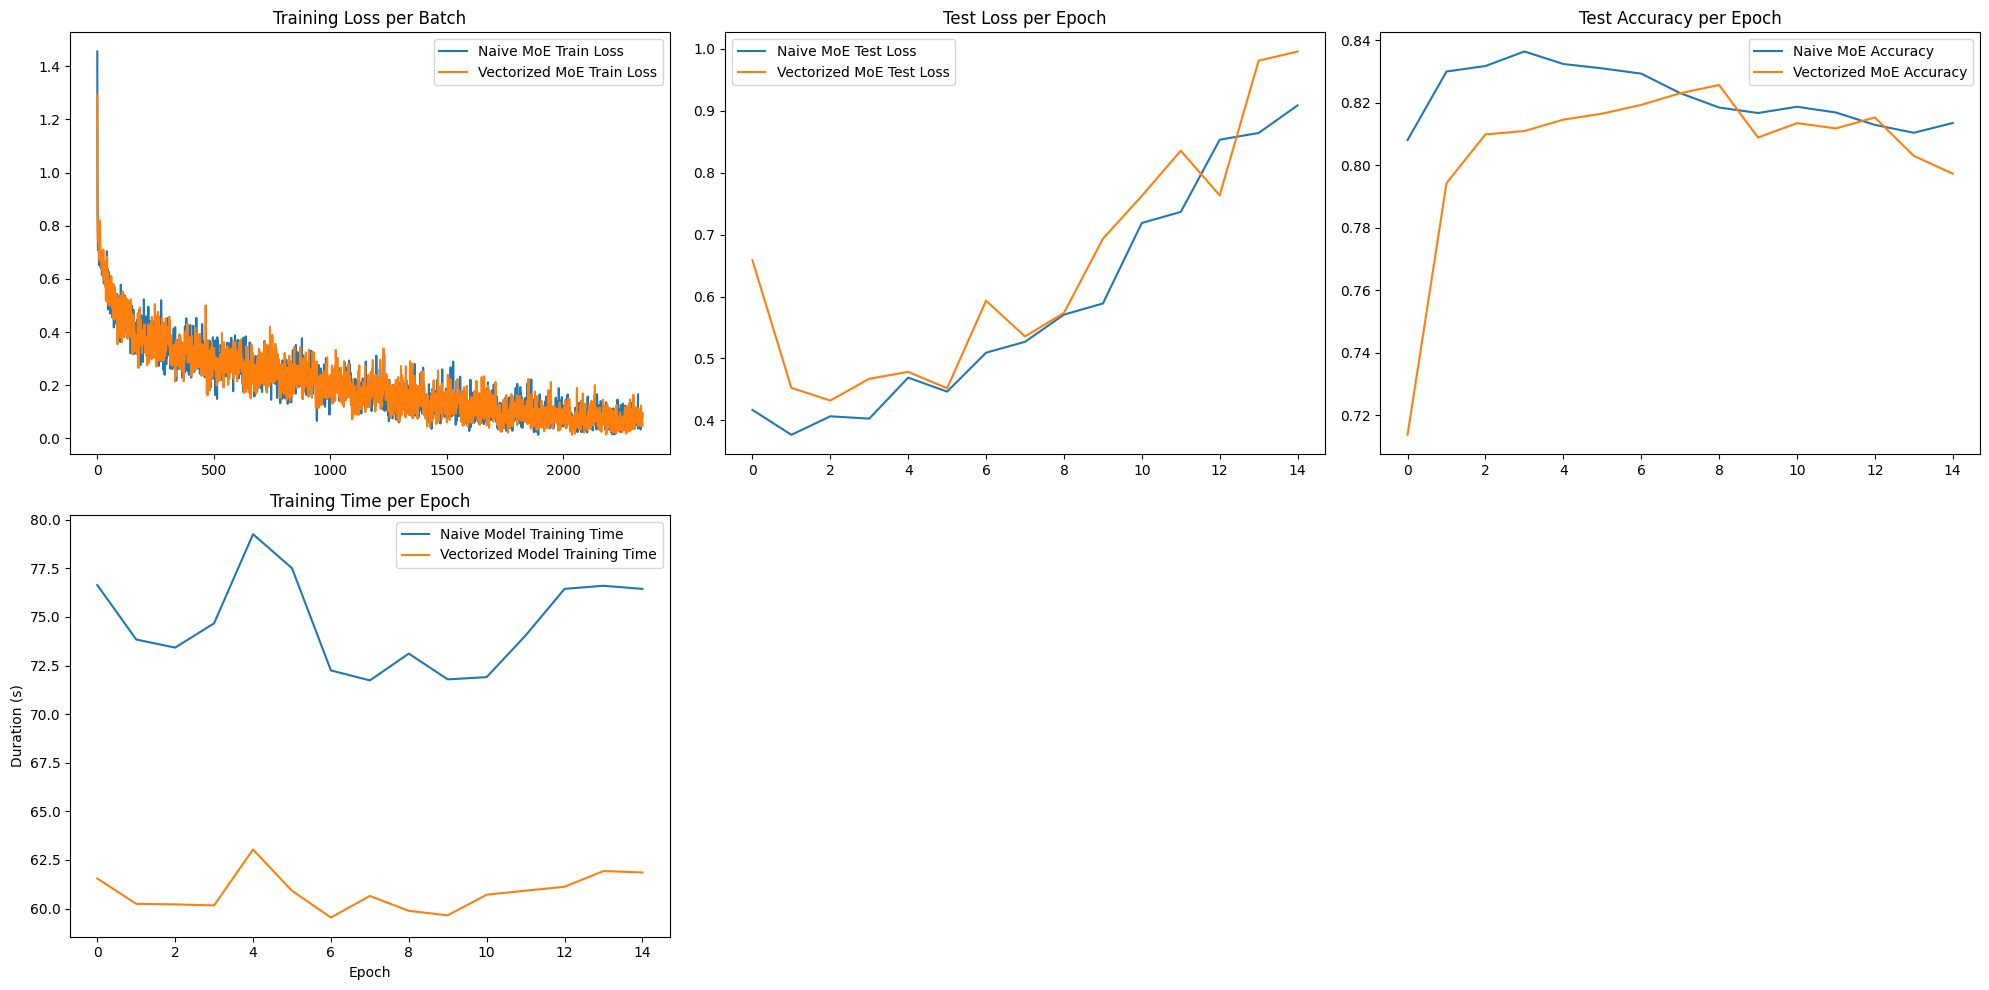

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Training and test loss
plt.subplot(2, 3, 1)
plt.plot(naive_train_losses, label='Naive MoE Train Loss')
plt.plot(vectorized_train_losses, label='Vectorized MoE Train Loss')
plt.title('Training Loss per Batch')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(naive_test_loss, label='Naive MoE Test Loss')
plt.plot(vectorized_test_loss, label='Vectorized MoE Test Loss')
plt.title('Test Loss per Epoch')
plt.legend()

# Accuracy
plt.subplot(2, 3, 3)
plt.plot(naive_test_acc, label='Naive MoE Accuracy')
plt.plot(vectorized_test_acc, label='Vectorized MoE Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()

# Epoch duration
plt.subplot(2, 3, 4)
plt.plot(naive_epoch_durations, label='Naive Model Training Time')
plt.plot(vectorized_epoch_durations, label='Vectorized Model Training Time')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Duration (s)')
plt.legend()

plt.tight_layout()
plt.show()

# **5. Bonus task. Using Huggingface's Trainer class and comparing performance of randomly initialized MoE Transformer and standard Transformer on https://huggingface.co/datasets/imdb dataset.**

In [30]:
vectorized_moe_config = PretrainedConfig(
    **base_config,
    num_experts=4,
    capacity_factor=2.0,
    num_experts_per_token=1,
    ff_cls=VectorizedMoE
)

vectorized_model = TransformerClassifier(vectorized_moe_config).to(DEVICE)

In [31]:
standard_config = PretrainedConfig(
    **base_config,
    ff_cls=MLP
)

standard_model = TransformerClassifier(standard_config).to(DEVICE)

In [34]:
from transformers import Trainer, TrainingArguments

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer_standard = Trainer(
    model=standard_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

trainer_moe = Trainer(
    model=vectorized_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
standard_result = trainer_standard.train()
moe_result = trainer_moe.train()

standard_eval = trainer_standard.evaluate()
moe_eval = trainer_moe.evaluate()

print("Standard Transformer Evaluation:", standard_eval)
print("MoE Transformer Evaluation:", moe_eval)

Epoch,Training Loss,Validation Loss
1,0.460500,0.396042
2,0.401500,0.366601
3,0.274500,0.390073
4,0.264400,0.427180
5,0.200600,0.457391
6,0.231200,0.467899
7,0.238800,0.534593
8,0.205100,0.552274
9,0.127400,0.620982
10,0.088200,0.692451


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Epoch,Training Loss,Validation Loss
1,0.401800,0.532444
2,0.364600,0.440849
3,0.289200,0.418412
4,0.272100,0.421925
5,0.192400,0.478237
6,0.198300,0.523411
7,0.329300,0.532292
8,0.122700,0.566462
9,0.123300,0.618880
10,0.068400,0.662319


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3500 already exists and is non-empty. Saving will proceed but saved res

Standard Transformer Evaluation: {'eval_loss': 0.6924508810043335, 'eval_runtime': 16.1547, 'eval_samples_per_second': 1547.538, 'eval_steps_per_second': 96.752, 'epoch': 10.0}
MoE Transformer Evaluation: {'eval_loss': 0.6623188853263855, 'eval_runtime': 23.8848, 'eval_samples_per_second': 1046.689, 'eval_steps_per_second': 65.439, 'epoch': 10.0}
